# Load data from Kaggle

In [1]:
# https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

{}

In [2]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

ls: cannot access 'kaggle.json': No such file or directory


In [3]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [4]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [5]:
# Download data from Kaggle using its API
!kaggle competitions download -c vsb-power-line-fault-detection

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [6]:
# https://stackoverflow.com/questions/49685924/extract-google-drive-zip-from-google-colab-notebook
!unzip /content/train.parquet.zip
# !unzip /content/test.parquet.zip

unzip:  cannot find or open /content/train.parquet.zip, /content/train.parquet.zip.zip or /content/train.parquet.zip.ZIP.


# Load Libraries

In [7]:
!sudo apt-get install libsnappy-dev
!pip install python-snappy
!pip install fastparquet
!pip install kneed

# https://github.com/raphaelvallat/entropy/issues/4#issue-533857629
!pip install git+https://github.com/raphaelvallat/entropy.git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libsnappy-dev
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 27.2 kB of archives.
After this operation, 108 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libsnappy-dev amd64 1.1.7-1 [27.2 kB]
Fetched 27.2 kB in 0s (97.6 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libsnappy-dev:amd64.
(Reading database ... 145483 files and

In [8]:
import numpy as np
import pandas as pd
import dask as dd
import pyarrow.parquet as pq
import pyarrow as pa
import os
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from scipy.stats import norm, skew

import gc
import pywt
from statsmodels.robust import mad
import scipy
from scipy import signal
from scipy.signal import butter
from scipy.signal import find_peaks, peak_widths, peak_prominences

from datetime import datetime

from scipy.signal import periodogram
from sklearn.neighbors import KDTree

from keras.layers import *
from keras.models import *
from keras import backend as K # The backend gives us access to tensorflow operations and allow us to create attention class
from keras import optimizers # Allows to access Adam class and modify some parameters
from keras.callbacks import * # This object helps the model to train in a smarter way, avoid overfitting
from keras import activations
from keras import regularizers
from keras import initializers
from keras import constraints
from keras.utils.vis_utils import plot_model
import tensorboard
%load_ext tensorboard
import tensorflow.compat.v1 as tf

# https://stackoverflow.com/a/56569206/4699076
tf.disable_eager_execution()

from sklearn.model_selection import GridSearchCV, StratifiedKFold

import concurrent.futures
import multiprocessing
from kneed import KneeLocator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import SGDRegressor
from IPython.display import Image
from sklearn.metrics import matthews_corrcoef
import numba
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix

import scipy.stats as stats
import pylab
from sklearn.ensemble import RandomForestClassifier
import random
import pickle
from sklearn.metrics import log_loss
from entropy import *
from prettytable import PrettyTable
import lightgbm as lgb

from sklearn.preprocessing import OneHotEncoder
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
from google.colab import drive
from google.colab import output
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
path = '/content/drive/My Drive/Colab Notebooks/Assignment_29-VSB_Power_Line/'
test_path = '/content/drive/My Drive/Colab Notebooks/Assignment_29-VSB_Power_Line/test_path'

# Read Data

In [ ]:
metadata_train = pd.read_csv("/content/metadata_train.csv")
metadata_test = pd.read_csv("/content/metadata_test.csv")

# train = pd.read_parquet('/content/train.parquet', engine='fastparquet')
# test = pd.read_parquet('/content/test.parquet', engine='fastparquet')

# Featurization

## Utility Functions

**General**

In [11]:
def parallel_proc_func(func, cols, no_signals, init_offset, 
                       save_file_path='None', *args):
  """
  Perform parallel processing of the given function. 
  If a function has to be parallelized over several items (signal_ids), then they
  can be parallelized based on the number of cores present in the CPU.
  The results are stored in a csv file.

  Parameters
  ----------
  func : function object
    The function which is to be run parallely.
  cols : numpy.ndarray
    Names of the result columns that is to be stored in the csv file
  no_signals : int
    Total number of signals to be processed
  init_offset : int
    Initial offset of the item (signal_id) from where the iterations are to begin
  save_file_path : string (Default - 'None')
    Path of the csv file where the results are to be stored.
    If None, resulting dataframe is returned.
  *args : Tuple
    Additional parameters (along with signal id) that are needed for the func 
    object.  

  Returns
  -------
  None (Default)
    If the file has to be saved, then the resultant data frame is stored in the
    respective save_file_path. Hence, nothing is returned.
  df : pandas.DataFrame
    If the file is not to be saved, then the resultant data frame is returned.
  """
  # Get number of cores in cpu: https://stackoverflow.com/a/1006337/4699076
  batch_size = multiprocessing.cpu_count() # no. of cores in the cpu, needed for parallel processing  
  end_val = no_signals//batch_size
  # Save the file after processing (save_pt*batch_size) number of signals
  save_pt = end_val//10
  if save_pt == 0:
    save_pt = 1

  # Check if file is already processed
  if os.path.isfile(save_file_path):
    df = pd.read_csv(save_file_path)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    start_val = df.shape[0]//batch_size
    print(f"{df.shape[0]} signal ids already processed.")
    print("Processing the remaining signal ids...")    
  else:
    # If specific columns are given, then create a dataframe with the given columns
    if cols != 'None':
      df = pd.DataFrame(columns=cols)
    # Create an empty dataframe if no columns given
    else:
      df = pd.DataFrame()
    if save_file_path != 'None':
      df.to_csv(save_file_path)
    
    start_val = 0
  
  start_batch = datetime.now()
  # Begin iteration
  for i in range(start_val, end_val):
    sig_id = np.arange(init_offset+(i*batch_size),
                        init_offset+(i*batch_size)+batch_size)
    # If additional arguments are provided for 'func' object, 
    # then create a list containing signal ids and new argument
    if len(args) != 0:
      func_args = [(x, args[0]) for x in sig_id]
    # If new arguments are not provided, then create a list of signal ids
    else:
      func_args = sig_id
    
    # Begin parallel processing
    with concurrent.futures.ProcessPoolExecutor() as executor:
      results = executor.map(func, func_args)
      for result in results:
        # For dataframe with pre-defined columns
        if cols != 'None':
          temp_df = pd.DataFrame(data=[result], columns=cols)
        # For dataframes with no pre-defined columns
        else:
          temp_df = pd.DataFrame(data=[result])
        df = df.append(temp_df, ignore_index=True)

    # Save file at the checkpoint
    if ((i+1)%save_pt==0):
      # Calculate and print the number of signals processed
      no_sigs_processed = (i+1)*batch_size
      print(f"{no_sigs_processed} ({np.round(((no_sigs_processed)/no_signals)*100, 2)}%) signals completed. Time taken: {datetime.now() - start_batch}")
      if save_file_path != 'None':
        df.to_csv(save_file_path)
      start_batch = datetime.now()

  # If all the signals are already processed, then start_val will be equal to end_val. 
  if start_val != end_val:
    no_signals_remaining = no_signals%batch_size
    if no_signals_remaining!=0:
      sig_id = np.arange(init_offset+(end_val*batch_size),
                        init_offset+(end_val*batch_size)+no_signals_remaining)
      if len(args) != 0:
        func_args = [(x, args[0]) for x in sig_id]
      else:
        func_args = sig_id

      # Parallel processing
      with concurrent.futures.ProcessPoolExecutor() as executor:
        results = executor.map(func, func_args)
        for result in results:
          if cols != 'None':
            temp_df = pd.DataFrame(data=[result], columns=cols)
          else:
            temp_df = pd.DataFrame(data=[result])
          df = df.append(temp_df, ignore_index=True)

  no_sigs_processed = no_signals
  print(f"{no_sigs_processed} ({np.round(((no_sigs_processed)/no_signals)*100, 2)}%) signals completed. Time taken: {datetime.now() - start_batch}")
  if save_file_path != 'None':
    df.to_csv(save_file_path)
  if save_file_path == 'None':
    return df

**Plots**

In [12]:
def get_knee(sorted_arr_len, vals_sorted, sensitivity, curve, direction):
  # https://github.com/arvkevi/kneed
  kneedle = KneeLocator(np.arange(len(vals_sorted)), vals_sorted, S=sensitivity, 
                        curve=curve, direction='increasing')
  knee = kneedle.knee_y
  knee_ind = kneedle.knee
  return knee, knee_ind  

def plot_knee(feat_name, vals_sorted, target_marker, knee, knee_ind, compare):
  """
  Plot the knee plot of the signal.

  Parameters
  ----------
  feat_name : string
    Name of the feature which is to be plotted.
    This is used for labelling the plot.
  vals_sorted : numpy.ndarray
    The x values of the plot.
  target_marker : numpy.ndarray
    Get the indices where the respective signal has target=1
  knee : numpy.float64
    The knee value of the series.
  knee_ind : int
    Index in the series where the knee value is obtained.
  compare : boolean
    If True the plot is displayed in the subplot. 
    If False then the entire space is used for the plot.
  
  Returns
  -------
  None : Function does not return any value
  """
  if not compare:
    plt.figure(figsize=(20,5))
  x_vals = np.arange(len(vals_sorted))  
  plt.plot(x_vals, vals_sorted, label='target=1', marker='s', markevery=target_marker)
  plt.plot(x_vals, vals_sorted, label='target=0')
  plt.vlines(knee_ind, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', label='Knee Value ({})'.format(knee))
  plt.legend()
  plt.xlabel('Signal Number')
  plt.ylabel(feat_name)
  if compare:
    plt.suptitle('{} Knee Plot - All Phases'.format(feat_name))
  else:
    plt.title('{} Knee Plot - All Phases'.format(feat_name))
    plt.show()
    print('='*100)

def plot_vs_sigid(temp_metadata, feat_name, target_index, knee, compare):
  """
  Plot the feature value of the signal with respect to its signal id.

  Parameters
  ----------
  temp_metadata : pandas.DataFrame
    Dataframe containing information of the features along with measurement id
    and target information for that measurement id.
  feat_name : string
    Name of the feature that is to be plotted.
  target_index : numpy.ndarray
    Index value where that respective measurement id has target=1
  knee : numpy.float64
    Knee value for that feature.
  compare : boolean
    If True the plot is displayed in the subplot. 
    If False then the entire space is used for the plot.

  Returns
  -------
  None : Function does not return any value  
  """
  x_vals = np.arange(temp_metadata.shape[0])
  if not compare:
    plt.figure(figsize=(25,10))
  plt.plot(x_vals, temp_metadata[feat_name].values, label='target=0')
  # https://stackoverflow.com/questions/21285885/remove-line-through-marker-in-matplotlib-legend
  plt.plot(x_vals, temp_metadata[feat_name].values, marker='s', markerfacecolor='red', 
          markevery=list(target_index), label='target=1', linestyle='None')
  plt.hlines(knee, plt.xlim()[0], plt.xlim()[1], linestyles='dashed', label='Knee Value ({})'.format(knee))
  plt.legend()
  plt.xlabel('Signal ID')
  plt.ylabel(feat_name)
  if compare:
    plt.suptitle('{} Vs. Signal ID'.format(feat_name))    
  else:    
    plt.title('{} Vs. Signal ID'.format(feat_name))
    plt.show()
    print('='*100)    

def plot_pdf(temp_metadata, feat_name, knee, compare):
  """
  Plot the Probability Density Function for the given feature.

  Parameters
  ----------
  temp_metadata : pandas.DataFrame
    Dataframe containing information of the features along with measurement id
    and target information for that measurement id.
  feat_name : string
    Name of the feature that is to be plotted.
  knee : numpy.float64
    Knee value for that feature.
  compare : boolean
    If True the plot is displayed in the subplot. 
    If False then the entire space is used for the plot.

  Returns
  -------
  None : Function does not return any value
  """
  target = temp_metadata[temp_metadata['target']==1][feat_name].values
  no_target = temp_metadata[temp_metadata['target']==0][feat_name].values

  if not compare:
    print("Mean of all {} values: {}".format(feat_name, np.mean(temp_metadata[feat_name].values)))
    print("Mean of {} with target=1: {}".format(feat_name, np.mean(target)))
    print("Mean of {} with target=0: {}".format(feat_name, np.mean(no_target)))  
    plt.figure(figsize=(15,5))

  ax1 = sns.distplot(temp_metadata[feat_name].values, kde=True, hist=False, label='combined')
  ax2 = sns.distplot(target, kde=True, hist=False, label='target=1')
  ax3 = sns.distplot(no_target, kde=True, hist=False, label='target=0', )

  ax1.axvline(np.mean(temp_metadata[feat_name].values), color='blue')
  ax2.axvline(np.mean(target), color='green')
  ax3.axvline(np.mean(no_target), color='red')

  plt.vlines(knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', label='Knee Value ({})'.format(knee))
  plt.legend()
  plt.xlabel(feat_name)
  plt.ylabel('PDF')
  if compare:
    plt.suptitle('PDF of {}'.format(feat_name))
  else:
    plt.title('PDF of {}'.format(feat_name))
    plt.show()
    print('='*100)

def plot_cdf(feat_name, vals_sorted, knee, compare):
  """
  Plot the Cumulative Density Function of the given feature.

  Parameters
  ----------
  feat_name : string
    Name of the feature that is to be plotted.
  vals_sorted : numpy.ndarray
    x values of the plot.
  knee : numpy.float64
    Knee value for that feature.
  compare : boolean
    If True the plot is displayed in the subplot. 
    If False then the entire space is used for the plot.

  Returns
  -------
  None : Function does not return any value
  """
  knee_perc = (((np.where(vals_sorted==knee)[0][0])/len(vals_sorted))*100)
  percentile_vals = []
  perc = 0
  for ind, val in enumerate(vals_sorted):
    if ind==int(perc*len(vals_sorted)):
      percentile_vals.append(val)      
      perc += 0.01
  percentile_vals.append(vals_sorted[-1])
  y_vals = np.linspace(0, 1, 101)

  if not compare:
    plt.figure(figsize=(15,5))
  plt.plot(percentile_vals, y_vals)
  plt.vlines(knee, plt.ylim()[0], plt.ylim()[1], linestyle='dashed', label='Knee Value ({})'.format(knee))
  plt.hlines((knee_perc/100), plt.xlim()[0], plt.xlim()[1], linestyles='dashdot', label='Knee Value Percentile ({}%)'.format(np.round(knee_perc,2)))
  plt.legend(loc='lower right')
  plt.xlabel(feat_name)
  plt.ylabel('CDF')
  if compare:
    plt.suptitle('CDF of {}'.format(feat_name))
  else:
    plt.title('CDF of {}'.format(feat_name))
    plt.show()
    print('='*100)

def plot_box(temp_metadata, feat_name, vals_sorted, knee, compare):
  """
  Plot the box plot for the given feature.

  Parameters
  ----------
  temp_metadata : pandas.DataFrame
    Dataframe containing information of the features along with measurement id
    and target information for that measurement id.  
  feat_name : string
    Name of the feature that is to be plotted.
  vals_sorted : numpy.ndarray
    x values of the plot.
  knee : numpy.float64
    Knee value for that feature.
  compare : boolean
    If True the plot is displayed in the subplot. 
    If False then the entire space is used for the plot.

  Returns
  -------
  None : Function does not return any value
  """
  knee_perc = (((np.where(vals_sorted==knee)[0][0])/len(vals_sorted))*100)
  sns.boxplot(x=temp_metadata['target'], y=temp_metadata[feat_name])
  plt.hlines(knee, plt.xlim()[0], plt.xlim()[1], linestyles='dashed', label='Knee Value Percentile ({}%)'.format(np.round(knee_perc,2)))
  plt.legend()
  if compare:
    plt.suptitle('Box plot of signals with target=0 and target=1')
  else:
    plt.title('Box plot of signals with target=0 and target=1')
    plt.show()  
    print('='*100)

def logistic_plot(temp_metadata, feat_name, compare):
  """
  Plot logistic plot for the given feature.

  Parameters
  ----------
  temp_metadata : pandas.DataFrame
    Dataframe containing information of the features along with measurement id
    and target information for that measurement id.  
  feat_name : string
    Name of the feature that is to be plotted.  
  compare : boolean
    If True the plot is displayed in the subplot. 
    If False then the entire space is used for the plot.

  Returns
  -------
  None : Function does not return any value

  References
  ----------
  .. [1] https://www.kaggle.com/mark4h/vsb-1st-place-solution
  """
  sns.set_context("paper", font_scale=2)
  # fig, ax = plt.subplots(1, 1, figsize=(8, 6))
  sns.regplot(feat_name, 'target', temp_metadata, logistic=True, 
              n_boot=100, y_jitter=.1, 
              scatter_kws={'alpha':0.1, 'edgecolor':'none'})
  if compare:
    plt.suptitle('Logistic plot of signals with target=0 and target=1')
  else:
    plt.title('Logistic plot of signals with target=0 and target=1')
    plt.show()
    print('='*100)

In [13]:
def feature_eda(temp_metadata, feat_name, plot_name, phase, compare, 
                sensitivity=1, curve='convex'):
  """
  Performs Exploratory Data Analysis for the given feature.

  Following information is displayed upon calling this function:
  * Knee plot
  * Feature value vs. signal id
  * PDF
  * CDF
  * Box plot
  * Logistic plot
  * Statistics

  Parameters
  ----------
  temp_metadata : pandas.DataFrame
    Dataframe containing information of the features along with measurement id
    and target information for that measurement id.  
  feat_name : string
    Name of the feature that is to be plotted.
  plot_name : string
    Name of the plot that is to be displayed.
    Following are the valid strings for the plot:
    * 'knee' - to display only knee plot
    * 'sigid' - to display only feature vs. signal id plot
    * 'pdf' - to display only the pdf plot
    * 'cdf' - to display only the cdf plot
    * 'box' - to display only the box plot
    * 'stats' - to display only statisticss
    * 'all' - to display all the plots and statistics
  phase : string
    This is to process the features with respect to signal id or with respect
    to measurement id.
    Following are valid strings:
    * 'one_phase' - when feature is calculated for each signal id
    * 'multi_phase' - when 3 phases of the signal is combined and processed
  compare : boolean
    If True plots are displayed in a subplot for comparing the two plots.
    If False then the entire space is used to display the plot.
  sensitivity : float (Default=1)
    This value adjusts the position where the knee value is to be detected.
  curve : string (Default='convex')
    How the values sorted in the ascending order look like.
    If 'convex' - sorted values look like exp(x) curve
    If 'concave' - sorted values look like sigmoid(x) curve
    
  Returns
  -------
  None : Function does not return any value
  """
  # Get the indices where the target is 1
  if phase=='one_phase':
    target_index = temp_metadata[temp_metadata['target']==1]['signal_id'].values
  elif phase=='multi_phase':
    target_index = temp_metadata[temp_metadata['target']==1]['id_measurement'].values

  # Sort the feature values in ascending order
  vals_sorted = np.sort(temp_metadata[feat_name].values)

  # Get the original indices of the sorted feature values
  vals_ind = np.argsort(temp_metadata[feat_name].values)

  # Get the original indices of the sorted feature values where target is 1
  target_marker = []
  for ind, val in enumerate(target_index):
    target_marker.append(np.where(vals_ind==val)[0][0])

  # https://github.com/arvkevi/kneed
  kneedle = KneeLocator(np.arange(len(vals_sorted)), vals_sorted, S=sensitivity, 
                        curve=curve, direction='increasing')
  knee = kneedle.knee_y
  knee_ind = kneedle.knee

  # If plot_name = 'all', then plot all the graphs
  # Else plot the respective graphs
  # Plot knee plot
  if (plot_name=='all') | (plot_name=='knee'):
    plot_knee(feat_name, vals_sorted, target_marker, knee, knee_ind, compare)
  
  if (plot_name=='all') & (not compare):
    print("The knee value of the {} is: {}".format(feat_name, knee))
    print(f"Number of signals with {feat_name} greater than {knee} and target=1: {len(np.where(np.array(target_marker) > knee_ind)[0])}({np.round((len(np.where(np.array(target_marker) > knee_ind)[0]) / temp_metadata.shape[0])*100 , 2)}%)")
    print(f"Number of signals with {feat_name} greater than {knee} and target=0: {len(np.where(vals_sorted > knee)[0])}({np.round((len(np.where(vals_sorted > knee)[0]) / temp_metadata.shape[0])*100 , 2)}%)")
    print("Number of signals with target=1: {}".format(len(target_index)))

  # Plot feature values vs signal id
  if (plot_name=='all') | (plot_name=='sigid'):
    plot_vs_sigid(temp_metadata, feat_name, target_index, knee, compare)

  # Plot PDF
  if (plot_name=='all') | (plot_name=='pdf'):
    plot_pdf(temp_metadata, feat_name, knee, compare)

  # Plot CDF
  if (plot_name=='all') | (plot_name=='cdf'):
    plot_cdf(feat_name, vals_sorted, knee, compare)

  # Plot box plot
  if (plot_name=='all') | (plot_name=='box'):
    plot_box(temp_metadata, feat_name, vals_sorted, knee, compare)
  
  # Plot logistic plot
  if (plot_name=='all') | (plot_name=='logistic'):
    logistic_plot(temp_metadata, feat_name, compare)
  
  # Print statistics
  if ((plot_name=='all') | (plot_name=='stats')) & (not compare):
    # https://stackoverflow.com/questions/34816769/getting-values-in-seaborn-boxplot
    stats = temp_metadata[feat_name].describe()
    print(f"Statistics of all signals:\n{stats}")    
    print(f"Inter Quartile Range of all Signals: {stats[6]-stats[4]}\n")

    stats = temp_metadata.groupby('target')[feat_name].describe().iloc[0]    
    print(f"Statistics of signals with target=0:\n{stats}")
    print(f"Inter Quartile Range of all signals with target=0: {stats[6]-stats[4]}\n")

    stats = temp_metadata.groupby('target')[feat_name].describe().iloc[1]
    print(f"Statistics of signals with target=1:\n{stats}")
    print(f"Inter Quartile Range of all signals with target=1: {stats[6]-stats[4]}\n")

def pca_plots(threshold_pos, threshold_neg, all_feats_df, cols, labels):
  """
  Plots PCA plot for the given data.

  Parameters
  ----------
  threshold_pos : float
    Positive threshold value for the mean correlation value for each feature.
    It will select only those features whose mean correlation value is less than
    this value.
  threshold_neg : float
    Negative threshold value for the mean correlation value for each feature.
    It will select only those features whose mean correlation value is greater 
    than this value.
  all_feats_df : pandas.DataFrame
    Dataframe containing all the feature values. 
    These feature values are not standardized.
  cols : list
    List of names of all the features.    

  Returns
  -------
  pca_df : pandas.DataFrame
    Dataframe comprising the reduced dimension.
  pca_cols : list
    List of strings specifying the selected columns for the given thresholds.
  pca.explained_variance_ : numpy.array
    Explained variance values (lambda) corresponding to each principal
    component.
  """  
  pca_cols = []
  # Select the features whose mean correlation value lies between positive and 
  # negative threshold values
  for ind, col in enumerate(cols):
    if mean_corr[ind] < threshold_pos and mean_corr[ind] > threshold_neg:
      pca_cols.append(col)
  # Standardize the features
  std = StandardScaler()
  s = std.fit_transform(all_feats_df[pca_cols])

  # Get all the principal components
  pca = PCA()
  pca_s = pca.fit_transform(s)
  pca_df = pd.DataFrame(pca_s[:,0:2], columns=['1st_principal', '2nd_principal'])
  pca_df['label'] = labels  
  return pca_df, pca_cols, pca.explained_variance_

def tsne_plots(threshold_pos, threshold_neg, all_feats_df, cols, labels, perp, iter):
  """
  Plots TSNE plot for the given data.

  Parameters
  ----------
  threshold_pos : float
    Positive threshold value for the mean correlation value for each feature.
    It will select only those features whose mean correlation value is less than
    this value.
  threshold_neg : float
    Negative threshold value for the mean correlation value for each feature.
    It will select only those features whose mean correlation value is greater 
    than this value.
  all_feats_df : pandas.DataFrame
    Dataframe containing all the feature values. 
    These feature values are not standardized.
  cols : list
    List of names of all the features.        
  perp : int
    Specify the required perplexity in the TSNE plot.
  iter : int
    Specify the number of iterations to run for the TSNE plot.

  Returns
  -------
  tsne_df : pandas.DataFrame
    Dataframe comprising the reduced dimension.    
  """
  tsne_cols = []
  # Select the features whose mean correlation value lies between positive and 
  # negative threshold values
  for ind, col in enumerate(cols):
    if mean_corr[ind] < threshold_pos and mean_corr[ind] > threshold_neg:
      tsne_cols.append(col)
  # Standardize the features
  std = StandardScaler()
  s = std.fit_transform(all_feats_df[tsne_cols])
  tsne = TSNE(n_components=2, perplexity=perp, n_iter=iter, random_state=42)
  tsne_s = tsne.fit_transform(s)
  tsne_df = pd.DataFrame(tsne_s, columns=['Dim_1','Dim_2'])
  tsne_df['label'] = labels
  return tsne_df  


In [14]:
plt_list = ['knee', 'sigid', 'pdf', 'cdf', 'box', 'logistic']
title_names = ['Original', 'Outlier processed']

def plot_compare(feat_name, phase, plt_list=plt_list, title_names=title_names, *args):
  """
  Display the plots side by side for comparison.

  Parameters
  ----------
  feat_name : string
    Name of the feature to be compared in the Dataframe 1.
  plt_list : list
    Names of the plots to be displayed
  original_df : pandas.DataFrame
    Dataframe 1 to be compared.
  denoised_df : pandas.DataFrame
    Dataframe 2 to be compared.
  phase : string
    This is to process the features with respect to signal id or with respect
    to measurement id.
    Following are valid strings:
    * 'one_phase' - when feature is calculated for each signal id
    * 'multi_phase' - when 3 phases of the signal is combined and processed

  Returns
  -------
  None : Function does not return any value
  """
  no_plts = len(plt_list)
  no_compares = len(args[0])  
  for ind, plt_name in enumerate(plt_list):    
    for args_val in args:
      plt.figure(figsize=(100,25))
      count = 0
      for df_ind, df in enumerate(args_val):
        count += 1               
        # plt.subplot(no_plts,no_compares,count)
        plt.subplot(1,no_compares,count)
        feature_eda(df, feat_name, plt_name, phase, True, 1)
        plt.title(title_names[df_ind])
      plt.show()
      print('='*150)

def plot_multi_compare(feat_list, phase, plt_list, df):
  """
  Display multiple plots side by side for comparison. 
  Here the comparison is among different features of the single dataframe.

  Parameters
  ----------
  feat_list : list
    List of names of the features to be compared in the Dataframe df.
  phase : string
    This is to process the features with respect to signal id or with respect
    to measurement id.
    Following are valid strings:
    * 'one_phase' - when feature is calculated for each signal id
    * 'multi_phase' - when 3 phases of the signal is combined and processed    
  plt_list : list
    Names of the plots to be displayed
  df : pandas.DataFrame
    Dataframe containing the features to be compared.

  Returns
  -------
  None : Function does not return any value
  """  
  no_plts = len(plt_list)
  no_compares = len(feat_list)    
  for ind, plt_name in enumerate(plt_list):
    plt.figure(figsize=(100,25))
    count = 0
    for feat_ind, feat_name in enumerate(feat_list):
      count += 1
      plt.subplot(1, no_compares, count)
      feature_eda(df, feat_name, plt_name, phase, True)
      plt.title(feat_name)
    plt.show()
    print('='*150)

def plot_multi_compare_1(feat_list, phase, plt_list, df):
  """
  Display multiple plots side by side for comparison.
  Here the comparison is among different features of the single dataframe. 
  This differs from plot_multi_compare in the number of plot that are compared.

  Parameters
  ----------
  feat_list : list
    List of names of the features to be compared in the Dataframe df.
  phase : string
    This is to process the features with respect to signal id or with respect
    to measurement id.
    Following are valid strings:
    * 'one_phase' - when feature is calculated for each signal id
    * 'multi_phase' - when 3 phases of the signal is combined and processed    
  plt_list : list
    Names of the plots to be displayed
  df : pandas.DataFrame
    Dataframe containing the features to be compared.

  Returns
  -------
  None : Function does not return any value
  """    
  no_plts = len(plt_list)
  no_cols = 3
  no_rows = np.ceil(len(feat_list)/no_cols)
  
  for ind, plt_name in enumerate(plt_list):
    # plt.figure(figsize=(no_rows*row_size,no_cols*col_size))
    plt.figure(figsize=(50,50))
    count = 0
    for feat_ind, feat_name in enumerate(feat_list):
      count += 1
      plt.subplot(no_rows, no_cols, count)
      feature_eda(df, feat_name, plt_name, phase, True)
      plt.title(feat_name)
    plt.show()
    print('='*150)

**Discrete Wavelet Transform**

In [17]:
def dwt_rand_plot(target_val):
  """
  Select the signals of the given class randomly from the training data and 
  plot the same. 

  Parameters
  ----------
  target_val : int
    The class of the signal from where the signals are to be selected randomly.
    target_val should be 0 or 1.
  no_signals : int
    Number of signals to be selected randomly.
    no_signals value should be between 0 and 8711 which refers to the signal_ids
    of the training data.

  Returns
  -------
  None
  """
  index_arr = metadata_train.query(f'target=={str(target_val)}').index.values
  # Counter to track number of signals selected randomly from the data
  rand_count = 0
  index = []  
  no_signals = 1
  # Select 5 signals with undamaged power line
  while (rand_count < no_signals):
      # Select a random value from 0 to 8711
      rand_val = np.random.randint(metadata_train['signal_id'].iloc[-1])
      # If the generated random integer is in 'index_arr' array and 
      # not in 'index' array, then add the integer to 'index' array
      if ((rand_val in index_arr) and (rand_val not in index)):
          index.append(rand_val)
          rand_count += 1

          # Plot the randomly selected signal
          plt.figure(figsize=(20,10))          
          plt.subplot(2,1,1)
          x = pd.read_parquet('/content/train.parquet', engine='fastparquet', columns=[str(rand_val)])
          plt.plot(x, label=f"Phase {metadata_train['phase'].loc[rand_val]} - Original")
          plt.title(f'signal_id: {rand_val}, target: {target_val}')
          plt.legend()          

          plt.subplot(2,1,2)
          x = dwt(x.values.flatten())
          plt.plot(x, label=f"Phase {metadata_train['phase'].loc[rand_val]} - Denoised")
          plt.title(f'signal_id: {rand_val}, target: {target_val}')
          plt.legend()
          plt.savefig(f'/content/dwt_{rand_val}_{target_val}.png')
          # Print the statistics of the signal          
          plt.show()
          
          print("="*100)

In [18]:
def dwt(x):
  """
  Apply DWT and Highpass filter on the signal. 
  Raw signal is first read, low frequency signals are removed and denoising is 
  done by DWT.
  Butterworth high pass digital filter is used to remove low frequency signals.

  Parameters
  ----------
  x : numpy.ndarray
    Raw signal.
  
  Returns
  -------
  x : numpy.ndarray
    Denoised signal.

  References
  ----------
  .. [1] https://www.kaggle.com/jackvial/dwt-signal-denoising
  .. [2] http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
  .. [3] Threshold equation and using hard mode in threshold as mentioned
         in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
         http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf  
  .. [4] https://www.dropbox.com/s/2ltuvpw1b1ms2uu/A%20Complex%20Classification%20Approach%20of%20Partial%20Discharges%20from%20Covered%20Conductors%20in%20Real%20Environment%20%28preprint%29.pdf?dl=0
  """      
  # Decompose to get the wavelet coefficients
  # 'db4' wavelet is used because of the expert setting mentioned in the References [4]
  # 'per' refers to periodic-padding, as the raw signal is a periodic one  
  wavlt_coeffs = pywt.wavedec(x, 'db4', mode="per")
  
  # Only the 1st level detailed coefficients are used to perform the thresholding and 
  # the 1s level approximate coefficients which contain low frequency compoenents (sine wave) are not used.
  # Calculation of sigma value to perform threholding, is also as per References [3]
  sigma = (1/0.6745) * np.mean(np.absolute(wavlt_coeffs[-1] - np.mean(wavlt_coeffs[-1],None)), None)
  # Calculate the universal threshold using Stein Unbiased Risk Estimate (SURE), as per References [3]
  Td = sigma * np.sqrt(2*np.log(len(x)))
  # The calculated threshold value is used to perform 'hard-thresholding' on all the 
  # other detailed coefficient values.
  wavlt_coeffs[1:] = (pywt.threshold(i, value=Td, mode='hard') for i in wavlt_coeffs[1:])

  # Reconstruct the signal using the thresholded coefficients
  x_dn = pywt.waverec(wavlt_coeffs, 'db4', mode='per')

  # Remove signals whose frequency is below 10KHz (References [4]) as the PD pattern 
  # is found mostly above 10KHz
  # Determine the cutoff frequency based on Nyquist criteria
  sample_rate = len(x)/0.02
  nyquist_rate = 0.5 * sample_rate
  cut_off = 1e4/nyquist_rate

  # Get the digital filter coefficients
  # Order=10 referring to the 'strictness' of the cutoff
  # Wn refers to the cutoff frequency value
  # btype refers to the type of filter to be used
  # output='sos' refers to second-order sections representations of IIR filter
  filter_coeffs = butter(10, Wn=[cut_off], btype='highpass', output='sos')
  # Apply the high pass filter on the DWT denoised signal
  x_dn_hp = signal.sosfilt(filter_coeffs, x_dn)

  return x_dn_hp

**Phase resolve features**

In [20]:
def phase_resolve(args):
  """
  Get the number of false, positive, and negative peaks present in each 
  location (I, II, III, IV quadrants) of the signal.

  Following procedure is used:
  *  Get the indices of true, false, symmetric, positive, negative peaks of the signal.
  *  Get the phase angle of the raw signal.
  *  Get the location of all the peaks for a 0 degree phase angled signal.
  *  Add the phase angle of the signal to the location of the peak.
  *  Aggregate the number of peaks in each quadrant.

  Note:
  Quadrants - 
  * I: 0 degree - 90 degree
  * II: 90 degree - 180 degree
  * III: 180 degree - 270 degree
  * IV: 270 degree - 360 degree

  Parameters
  ----------
  args : Tuple
    Tuple containing the following:
    * sig_id
    * sig_type - 'train' or 'test'
    * phase_cols - names of the required features
    * peak_val - minimum threshold value to consider a peak

  Returns
  -------
  phase_df : numpy.ndarray
    Following features are returned:
    * t_q0 - number of true peaks in I quadrant
    * t_q1 - number of true peaks in II quadrant
    * t_q2 - number of true peaks in III quadrant
    * t_q3 - number of true peaks in IV quadrant
    * f_q0 - number of false peaks in I quadrant
    * f_q1 - number of false peaks in II quadrant
    * f_q2 - number of false peaks in III quadrant
    * f_q3 - number of false peaks in IV quadrant
    * p_q0 - number of postive peaks in I quadrant
    * p_q1 - number of postive peaks in II quadrant
    * p_q2 - number of postive peaks in III quadrant
    * p_q3 - number of postive peaks in IV quadrant
    * n_q0 - number of negative peaks in I quadrant
    * n_q1 - number of negative peaks in II quadrant
    * n_q2 - number of negative peaks in III quadrant
    * n_q3 - number of negative peaks in IV quadrant    
  """
  sig_id = str(args[0])
  sig_type = args[1][0]
  phase_cols = args[1][1]
  peak_val = args[1][2]

  if sig_type == 'train':
    x = pd.read_parquet(path + 'train.parquet', engine='fastparquet', columns=[sig_id])
    x = x.values.flatten()
  elif sig_type == 'test':
    x = pd.read_parquet(path + 'test.parquet', engine='fastparquet', columns=[sig_id])
    x = x.values.flatten()

  x_dn = dwt(x)
  t, f, s, p, n = get_all_peaks(x_dn, peak_val)

  num_val = x.shape[0]
  # Takes cosine wave as reference.
  # 0 deg => 0 deg of cosine wave,
  # 90 deg => 90 deg phase shift of cosine wave
  omegas = np.exp(-2j * np.pi * np.arange(num_val) / num_val)
  sig_phase = omegas.dot(x)
  sig_phase_angle = np.angle(sig_phase, deg=False)

  dt = (20e-3/(800000))
  f1 = 50
  w1 = 2*np.pi*f1

  phase_df = pd.DataFrame(columns=phase_cols)
  phases = [0, 1, 2, 3]
  count = 0
  for peak_inds in [t, f, p, n]:
    peak_phase_angle_arr = []
    for ind in peak_inds:
      peak_phase_angle_arr.append((np.degrees((w1* ind *dt) + sig_phase_angle)) % 360)
    
    temp_df = pd.DataFrame(data=peak_phase_angle_arr, columns=['peak_arr'])
    temp_df['quadrant'] = pd.cut(x=peak_phase_angle_arr,
                                 bins=[0, 90, 180, 270, 360],
                                 labels=phases)
    phase_bins = temp_df['quadrant'].value_counts()
    for phase in phases:
      phase_df[phase_df.columns[count]] = phase_bins[phase_bins.index==phase].values
      count += 1
  
  return phase_df.values[0]

## Feature Engineering

### Phase Resolved features

#### Train data

In [ ]:
phase_cols = ['t_q0', 't_q1', 't_q2', 't_q3',
              'f_q0', 'f_q1', 'f_q2', 'f_q3',
              'p_q0', 'p_q1', 'p_q2', 'p_q3',
              'n_q0', 'n_q1', 'n_q2', 'n_q3']

save_file_path = path + f'phase_resolved_peaks_train.csv'

if not os.path.isfile(save_file_path):
  peak_val = int(np.load(path + f'best_peak_threshold.npy'))
  start_time = datetime.now()
  print(f"Start time: {start_time}")

  parallel_proc_func(phase_resolve, phase_cols, metadata_train.shape[0], metadata_train['signal_id'].loc[0], 
                     save_file_path, ('train', phase_cols, peak_val))

  print(f"Total time taken: {datetime.now()-start_time}")

phase_resolve_df = pd.read_csv(save_file_path)
phase_resolve_df.drop(['Unnamed: 0'], axis=1, inplace=True)
phase_resolve_df = pd.concat([metadata_train, phase_resolve_df], axis=1)

print(phase_resolve_df.shape)
phase_resolve_df.head()

(8712, 20)


signal_id  id_measurement  phase  target  t_q0  ...  p_q3  n_q0  n_q1  n_q2  n_q3
0          0               0      0       0    16  ...     5    12     5    21     5
1          1               0      1       0     5  ...     0     5     9     0     0
2          2               0      2       0    34  ...    11    22     6     3     9
3          3               1      0       1    20  ...    18    10     5     6     6
4          4               1      1       1     3  ...     5     3    41     2     0

[5 rows x 20 columns]

#### Analysis

##### False peaks

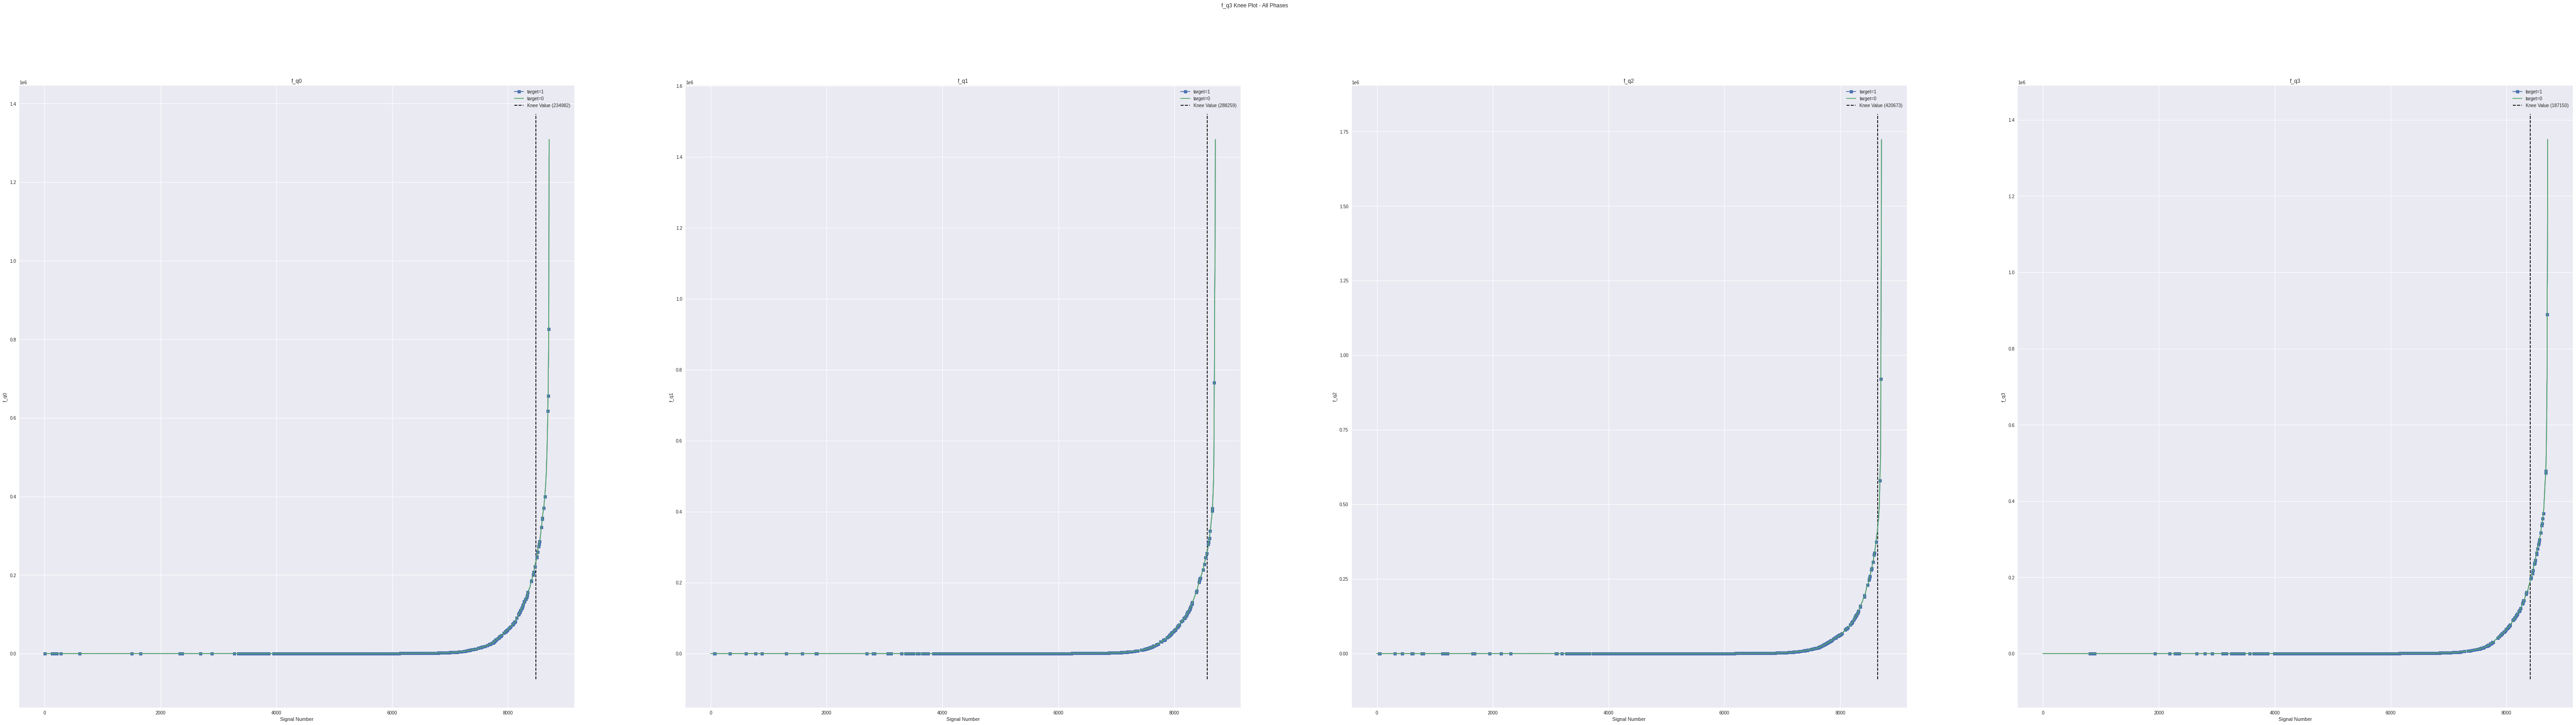

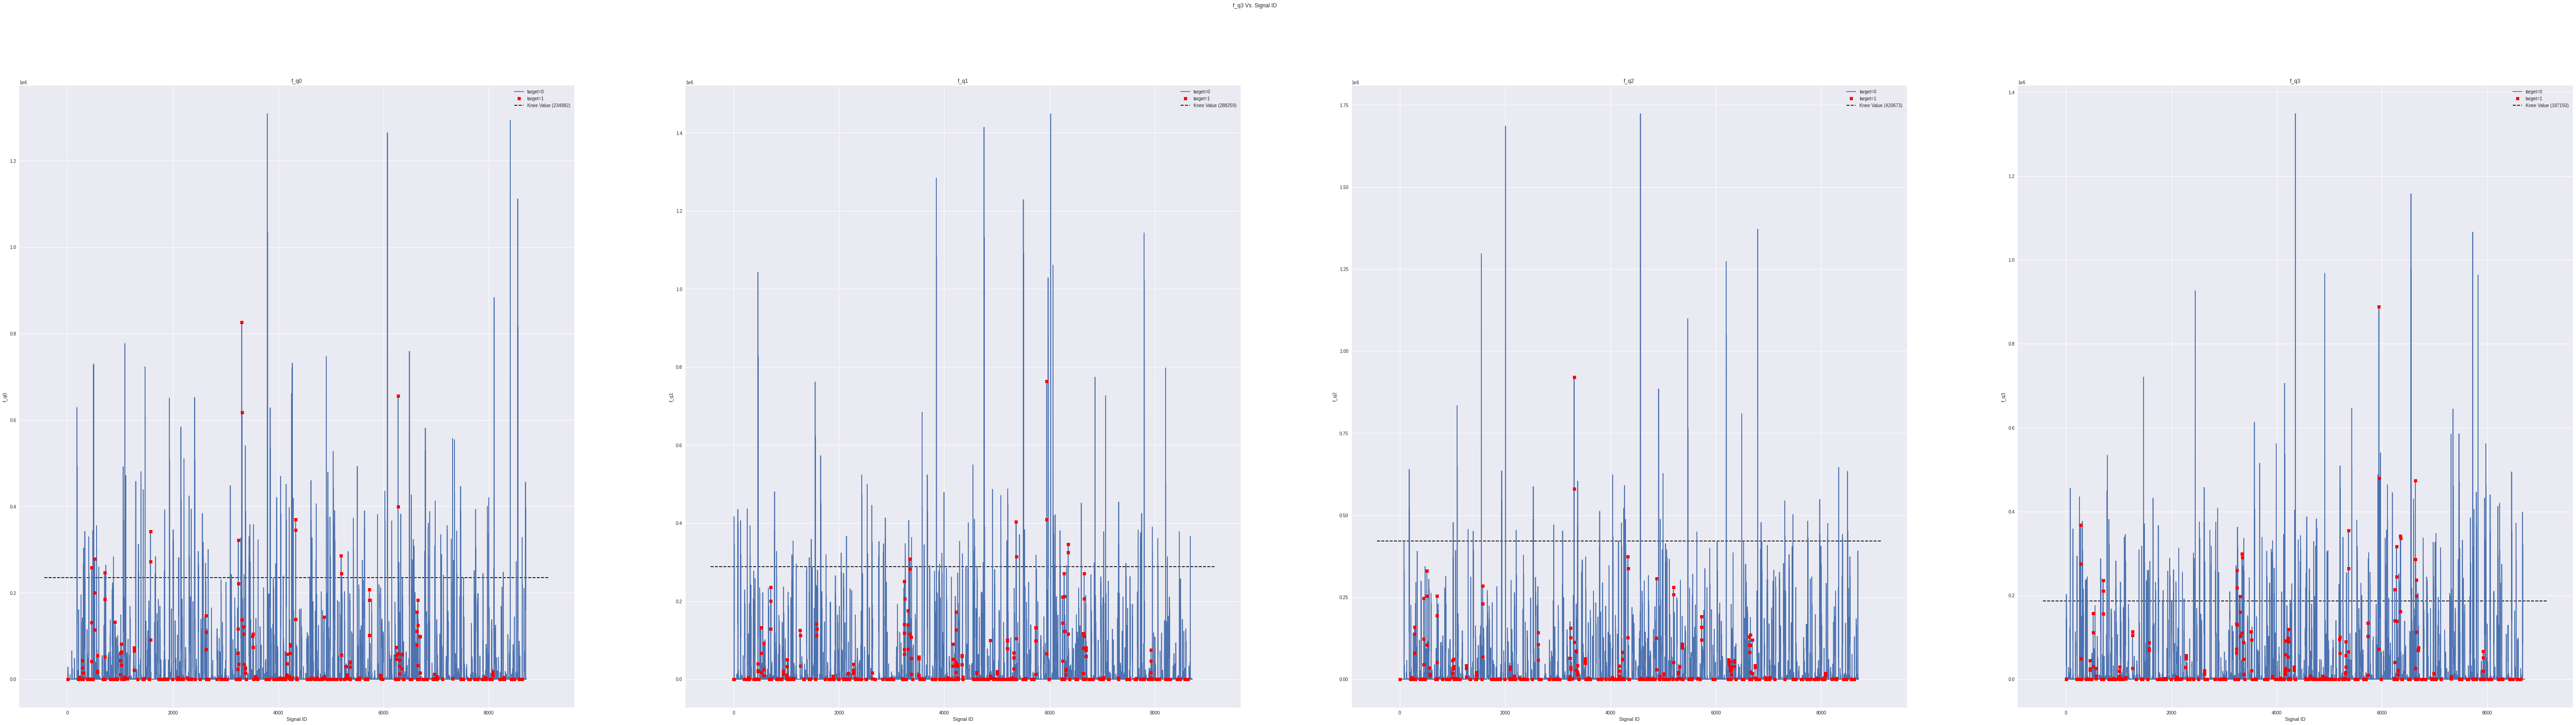

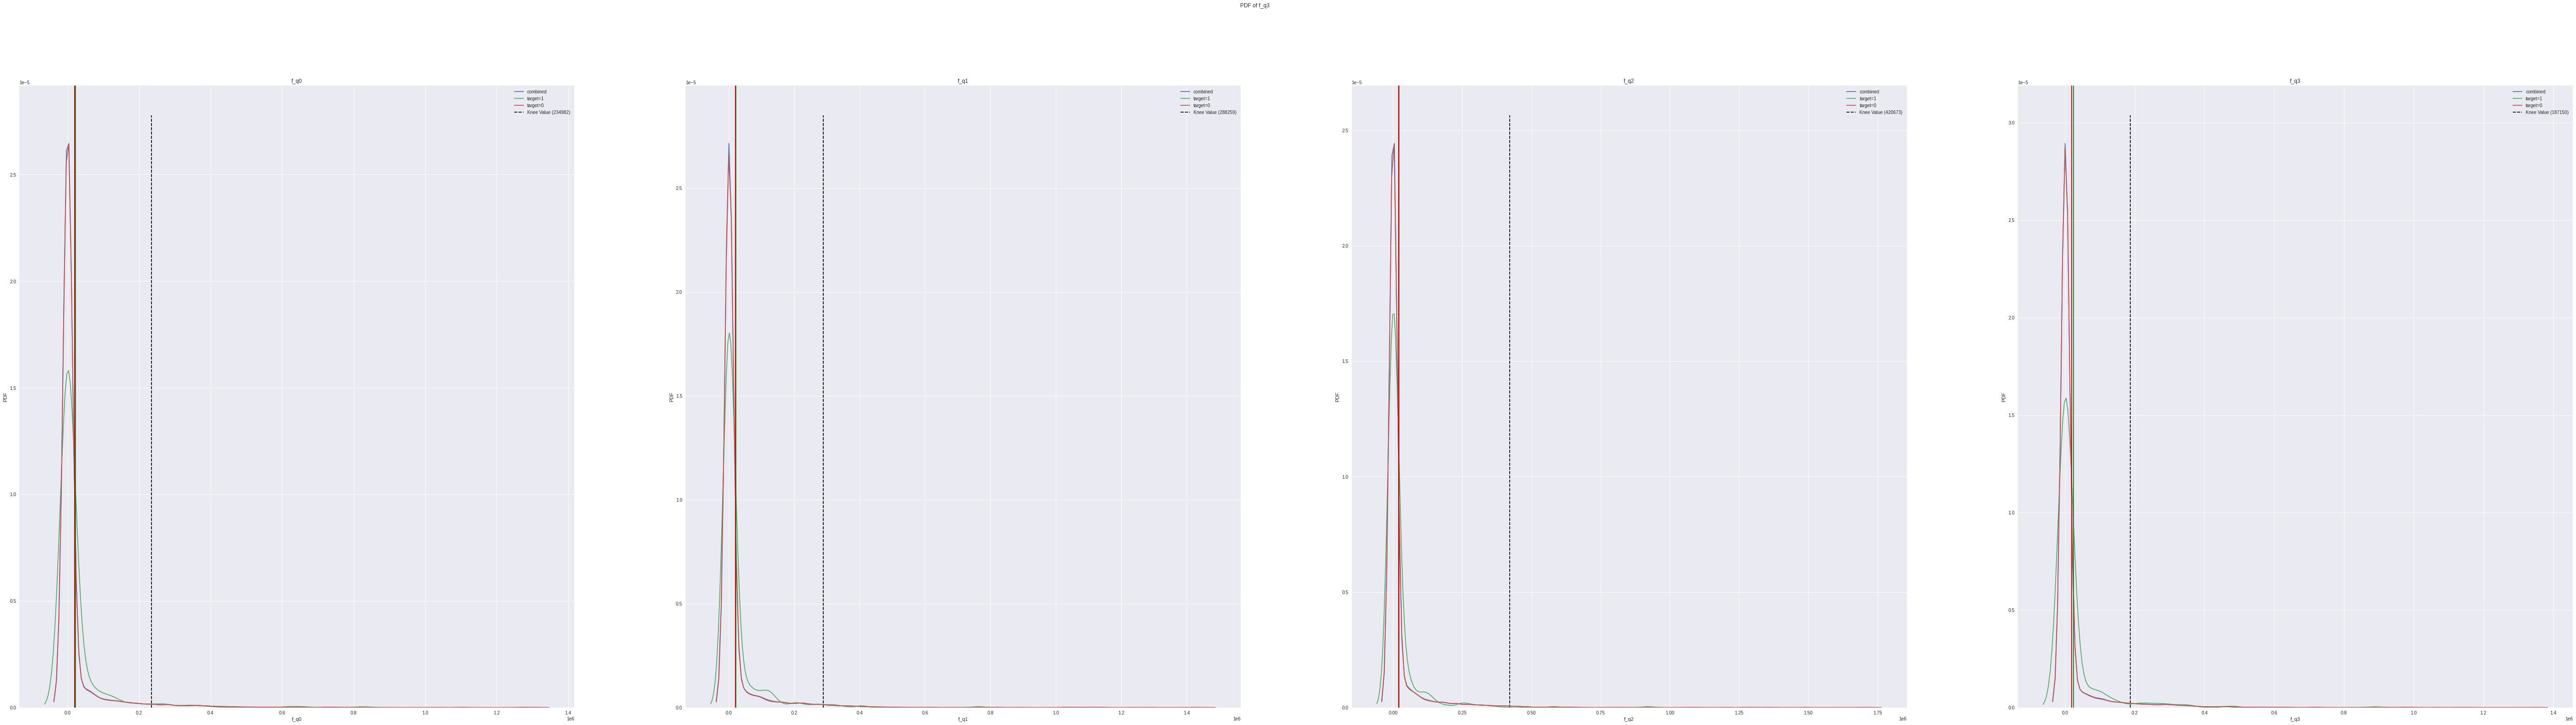

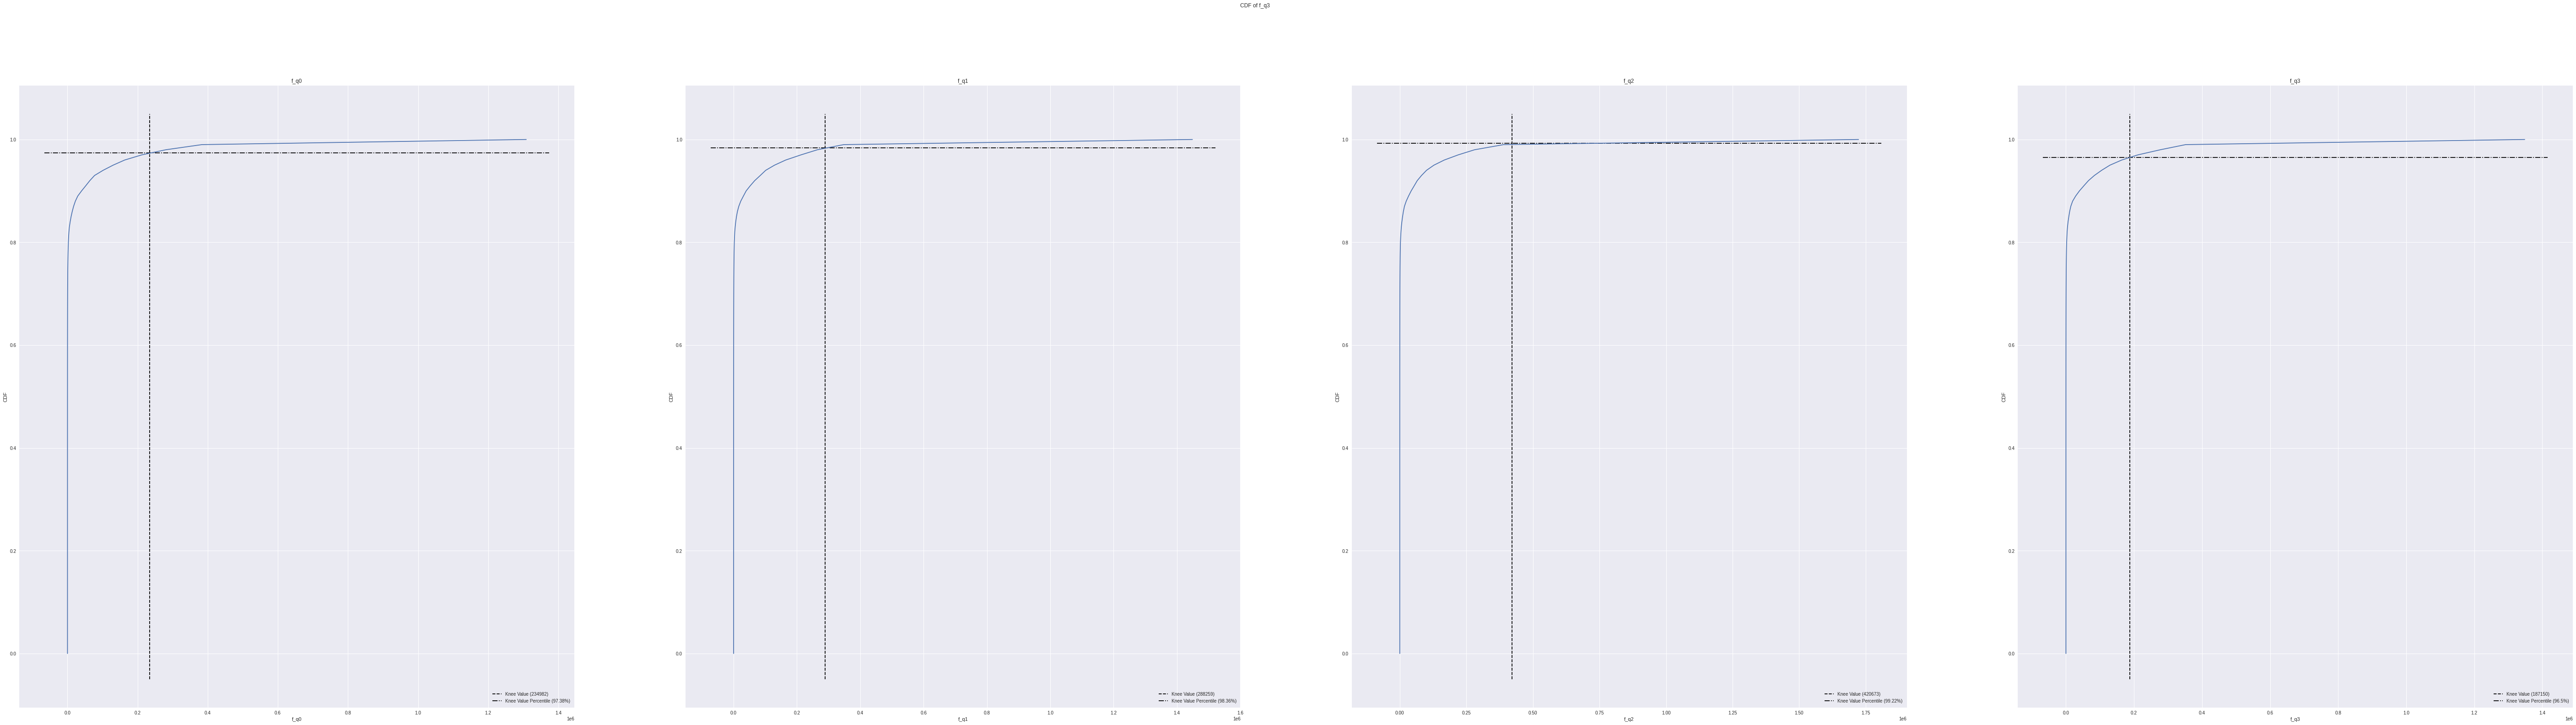

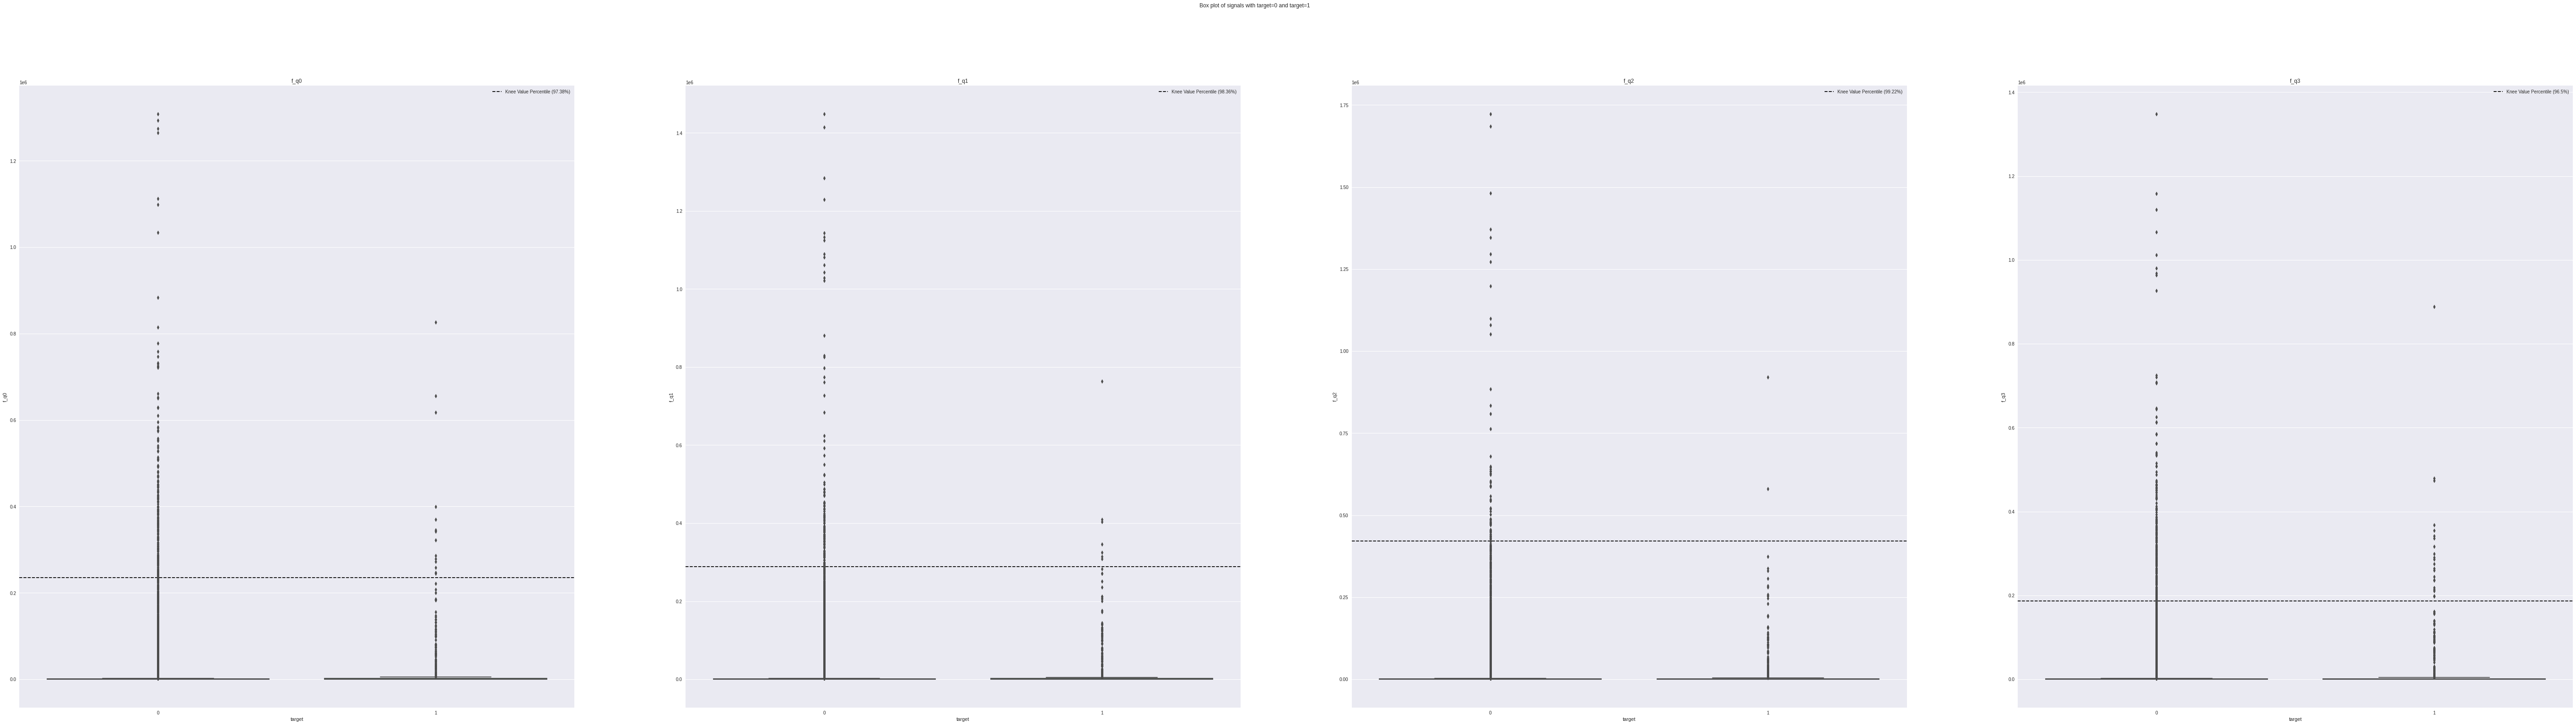

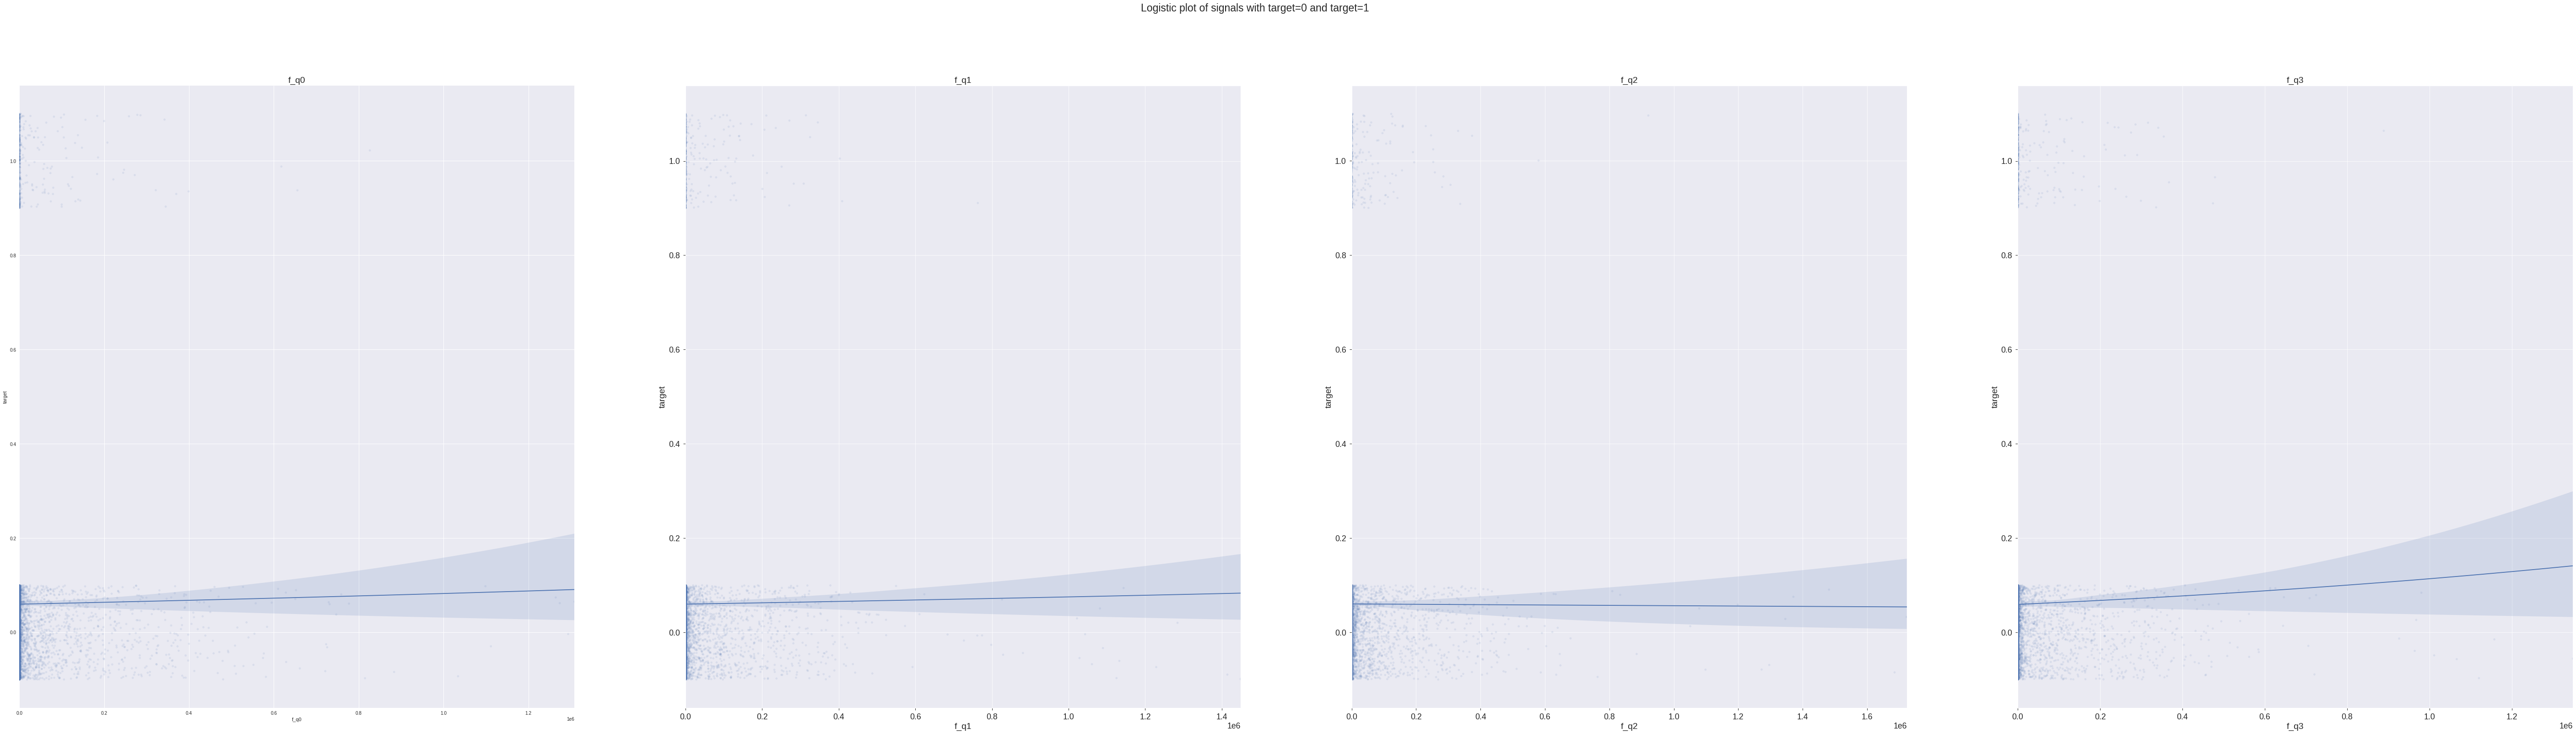

In [ ]:
feat_list = ['f_q0', 'f_q1', 'f_q2', 'f_q3']
plot_multi_compare(feat_list, 'one_phase', plt_list, phase_resolve_df)

##### Positive peaks

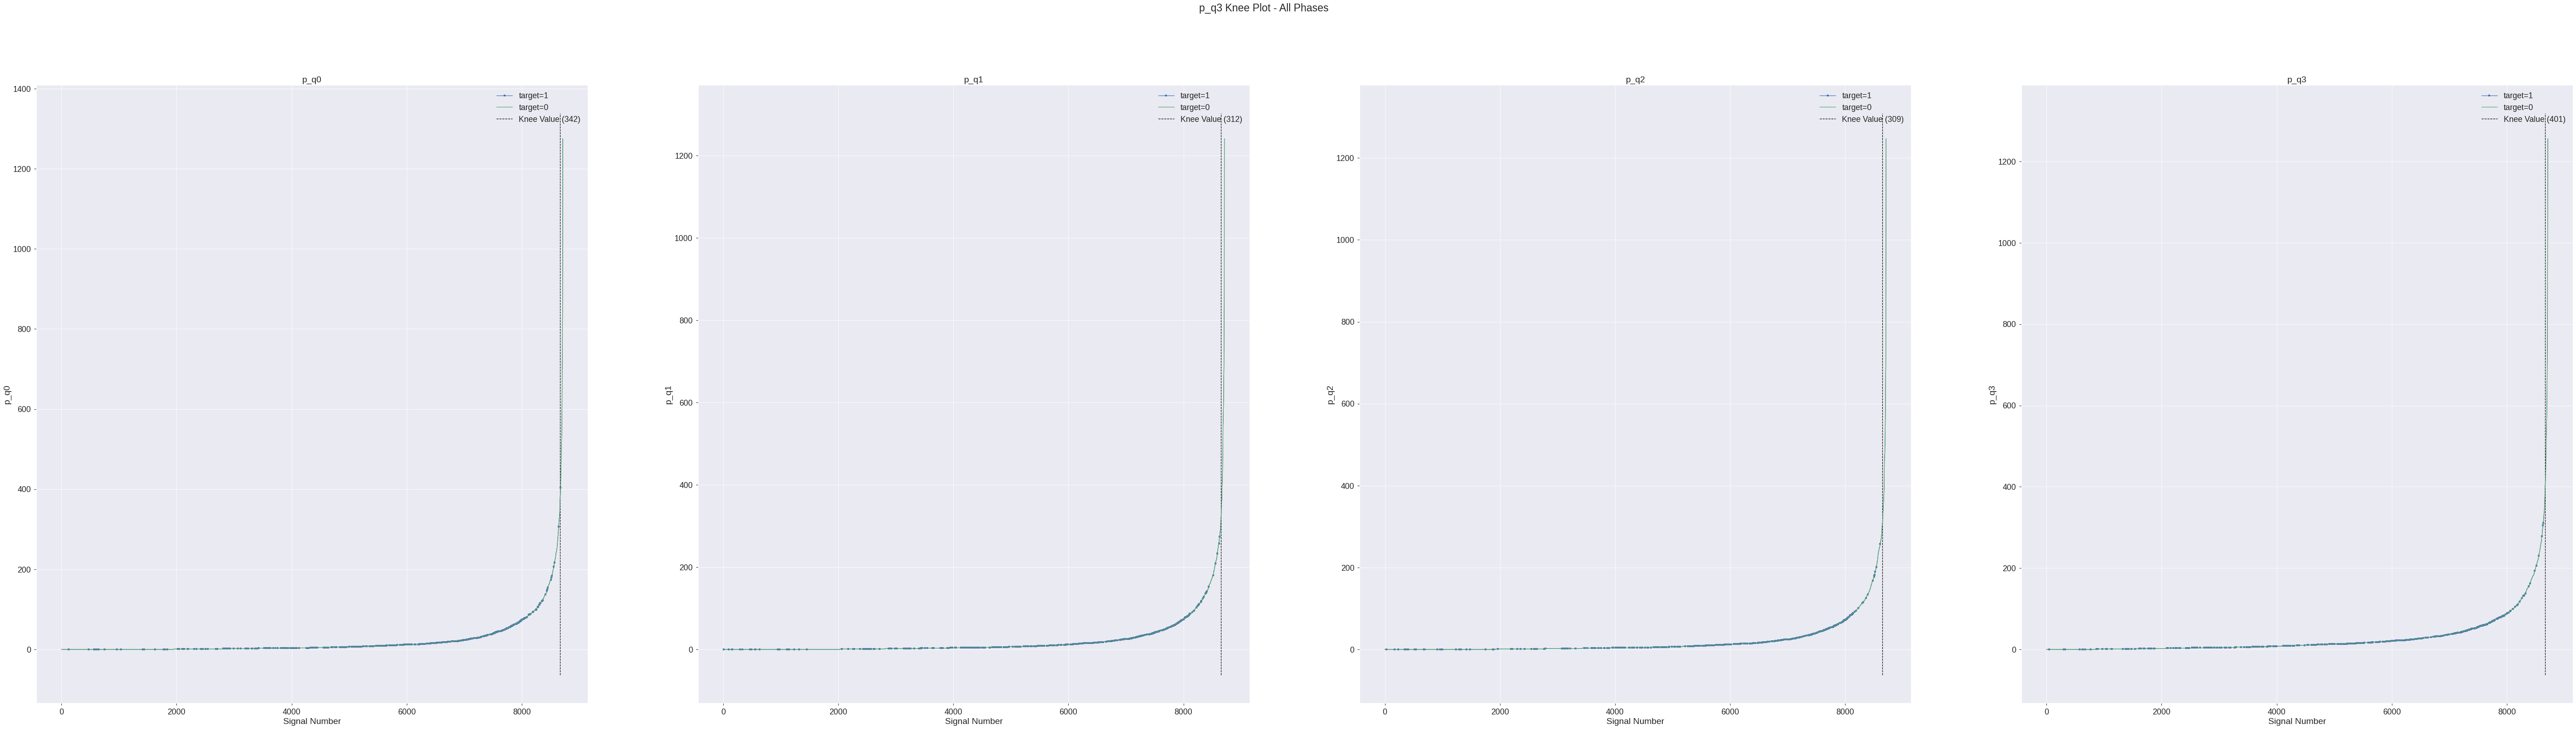

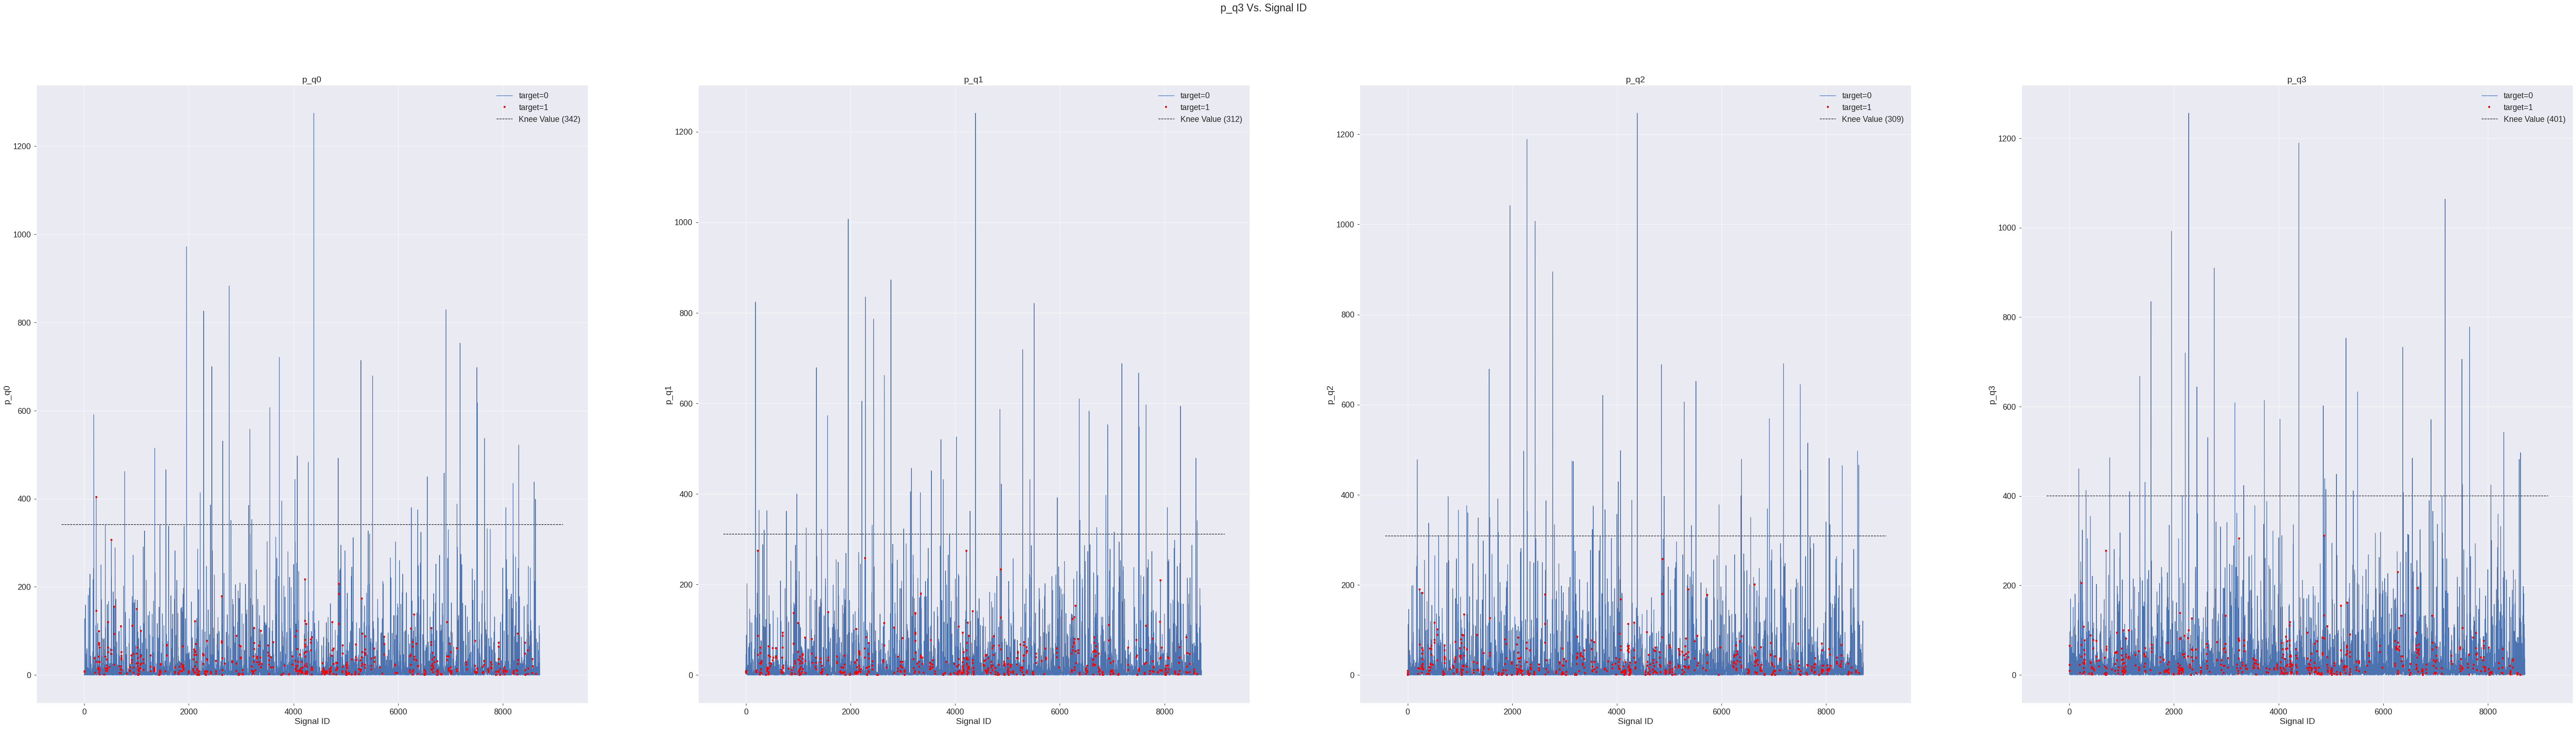

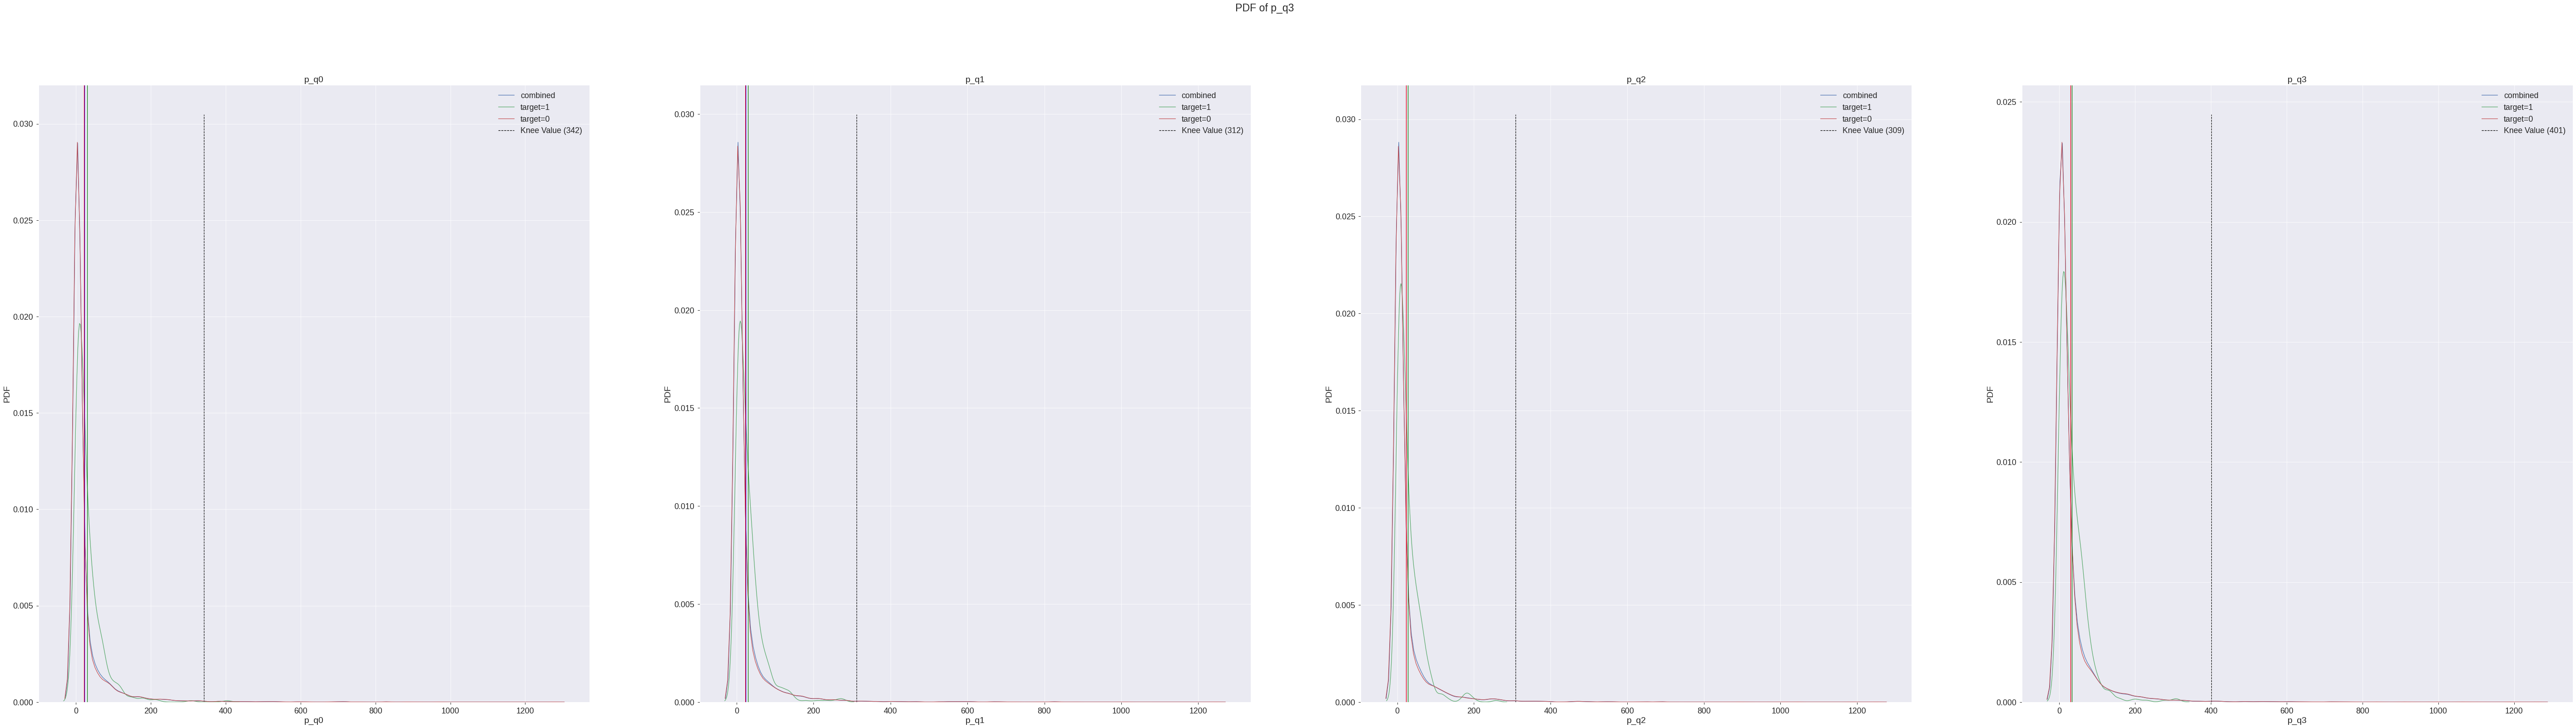

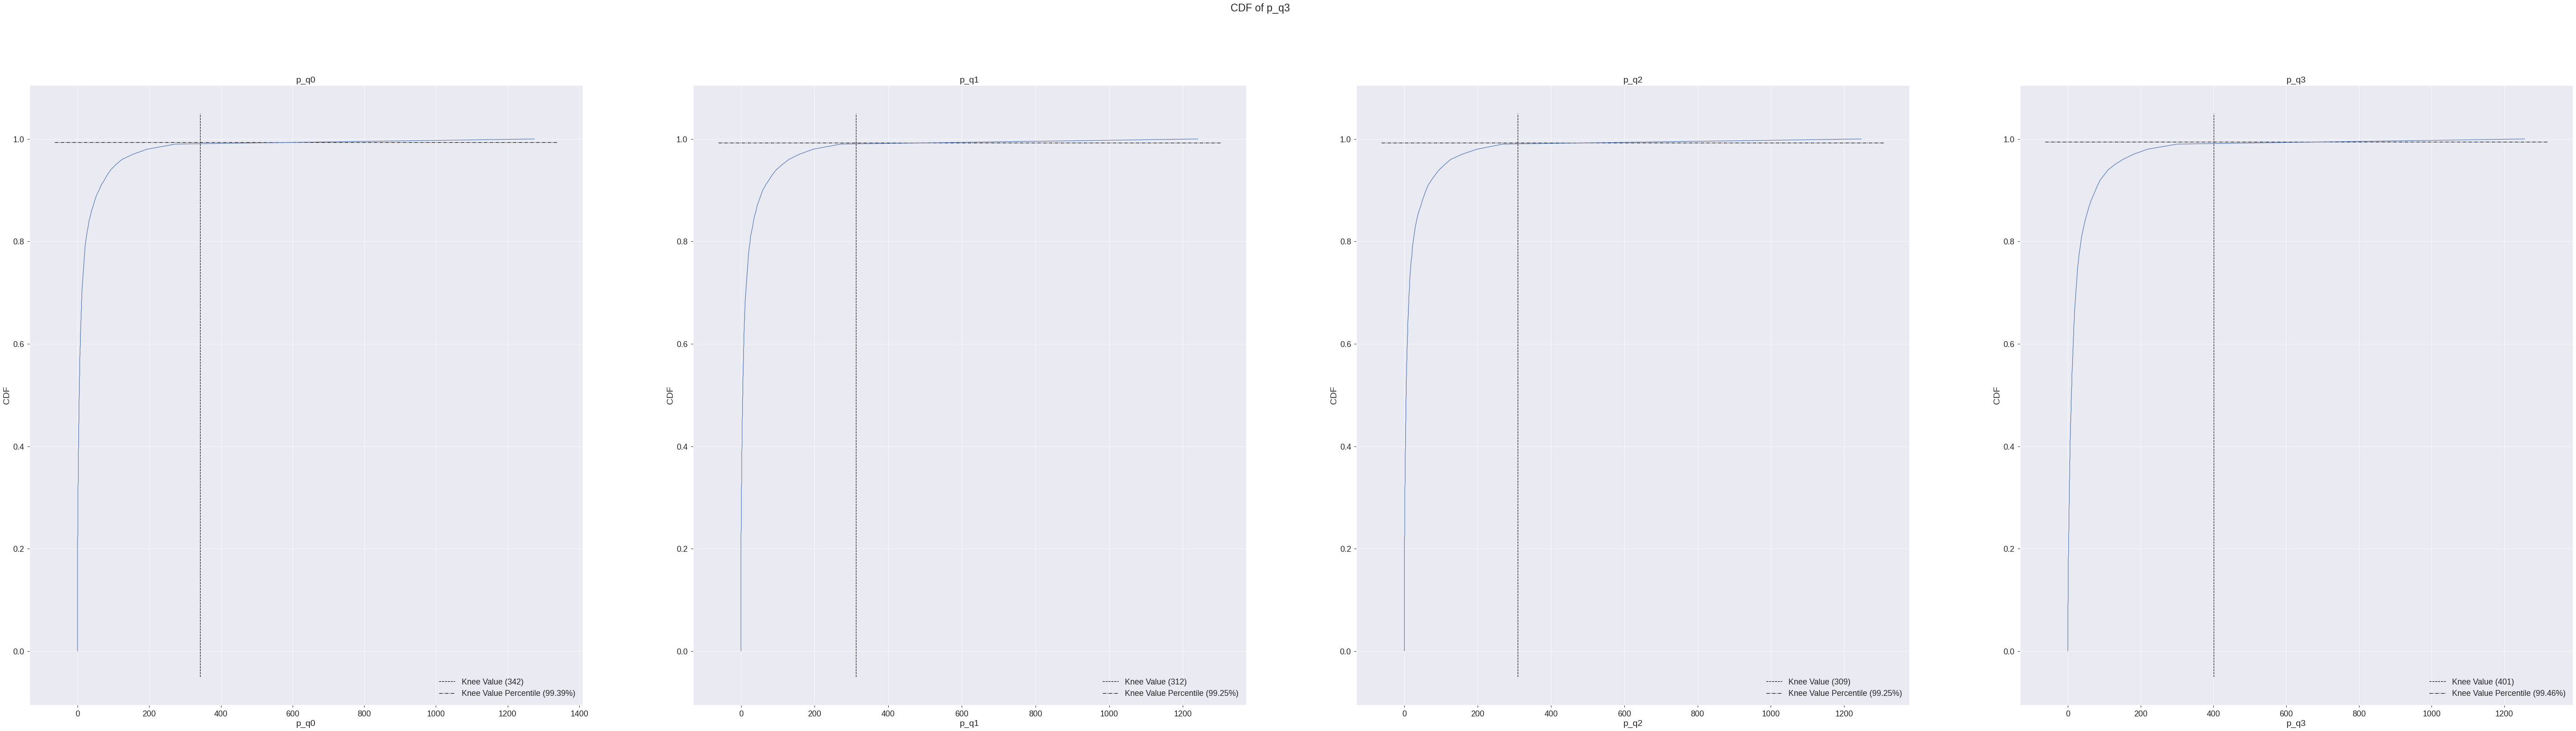

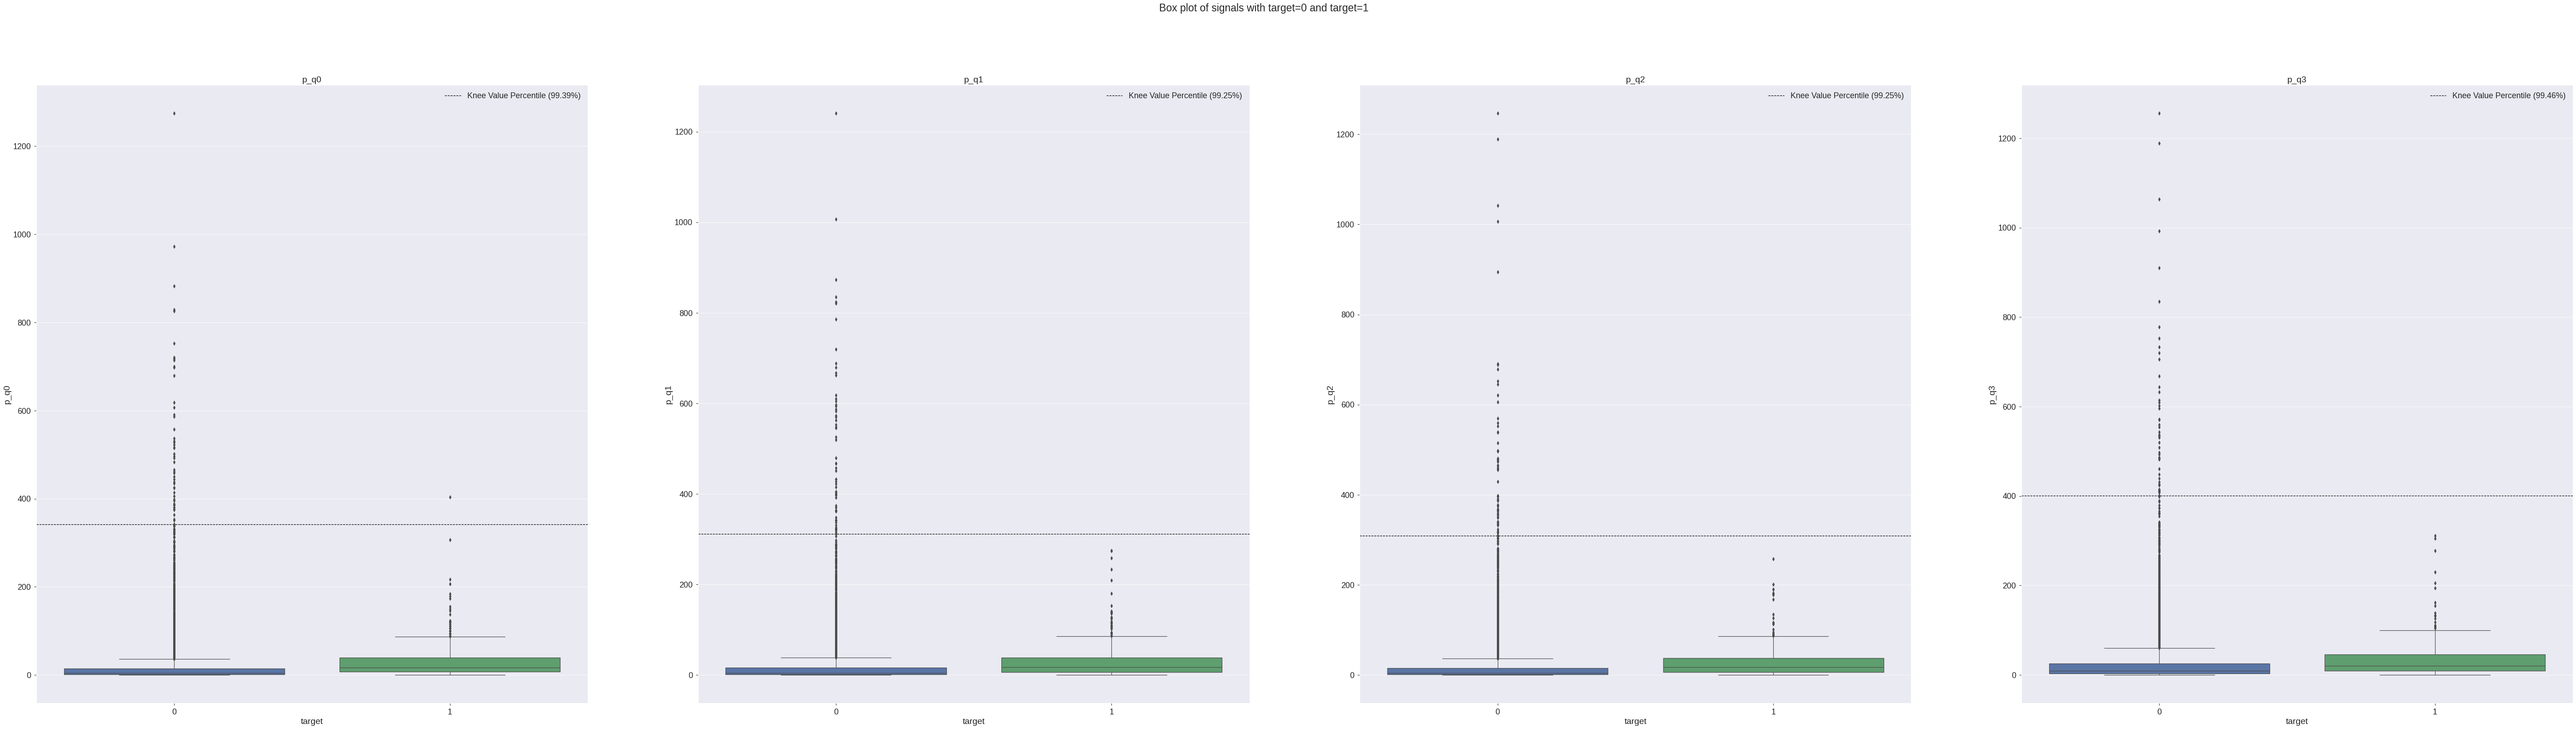

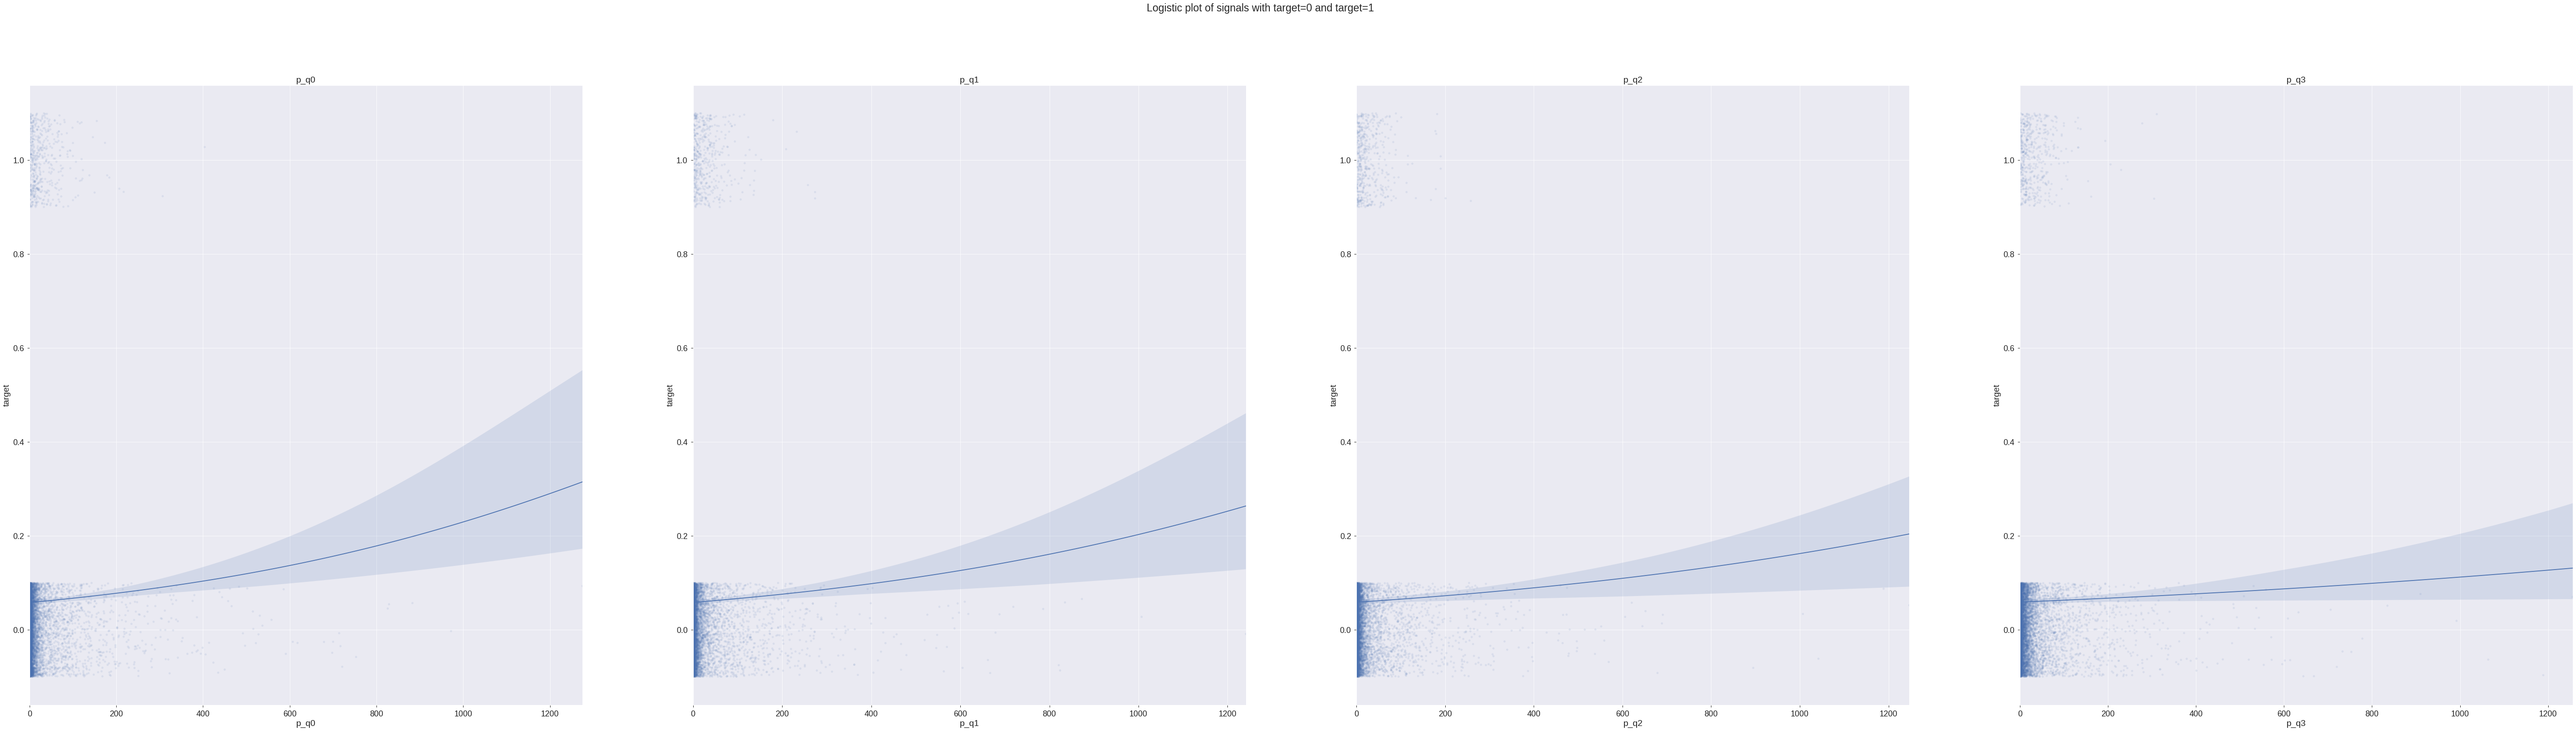

In [ ]:
feat_list = ['p_q0', 'p_q1', 'p_q2', 'p_q3']
plot_multi_compare(feat_list, 'one_phase', plt_list, phase_resolve_df)

Observations:
*  Most of the positive peaks in each quadrant is less than 400
*  IQRs of signals with target=1 and target=0 do overlaps in all the quadrants.
*  Positive peaks in any of the quadrant is not good enough to be separated linearly.

##### Negative peaks

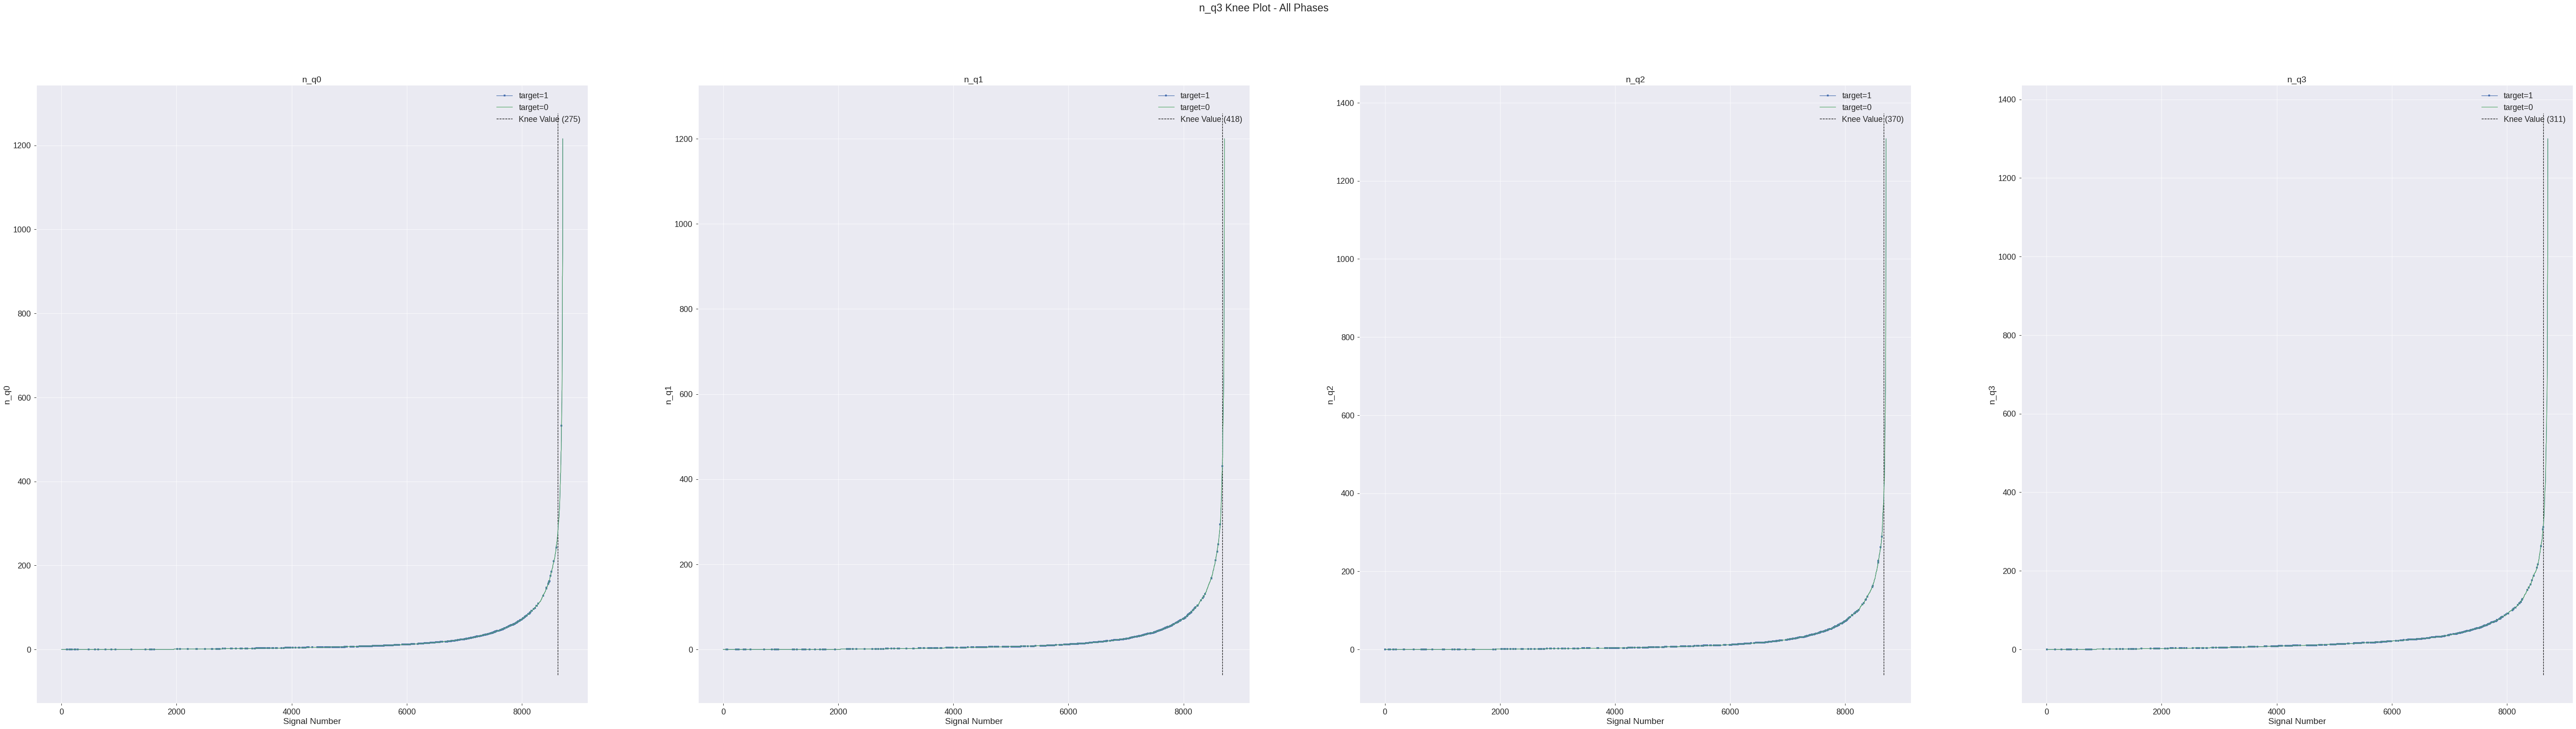

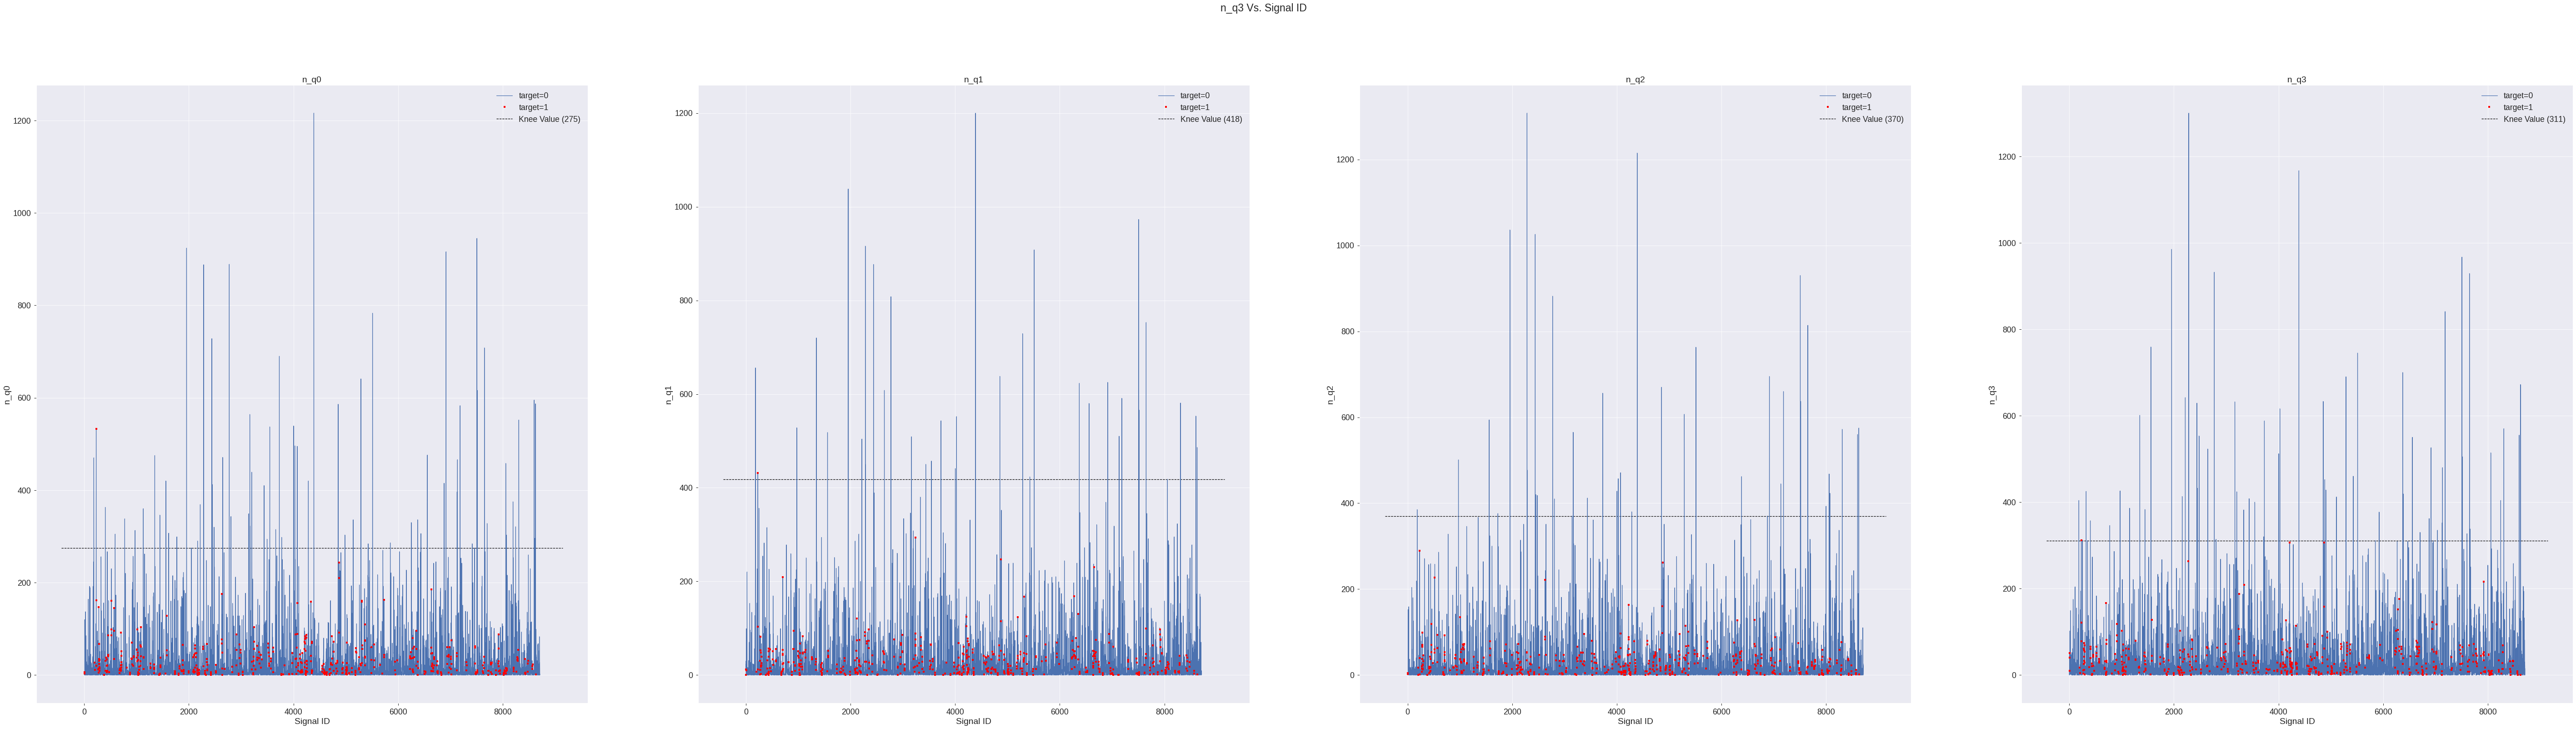

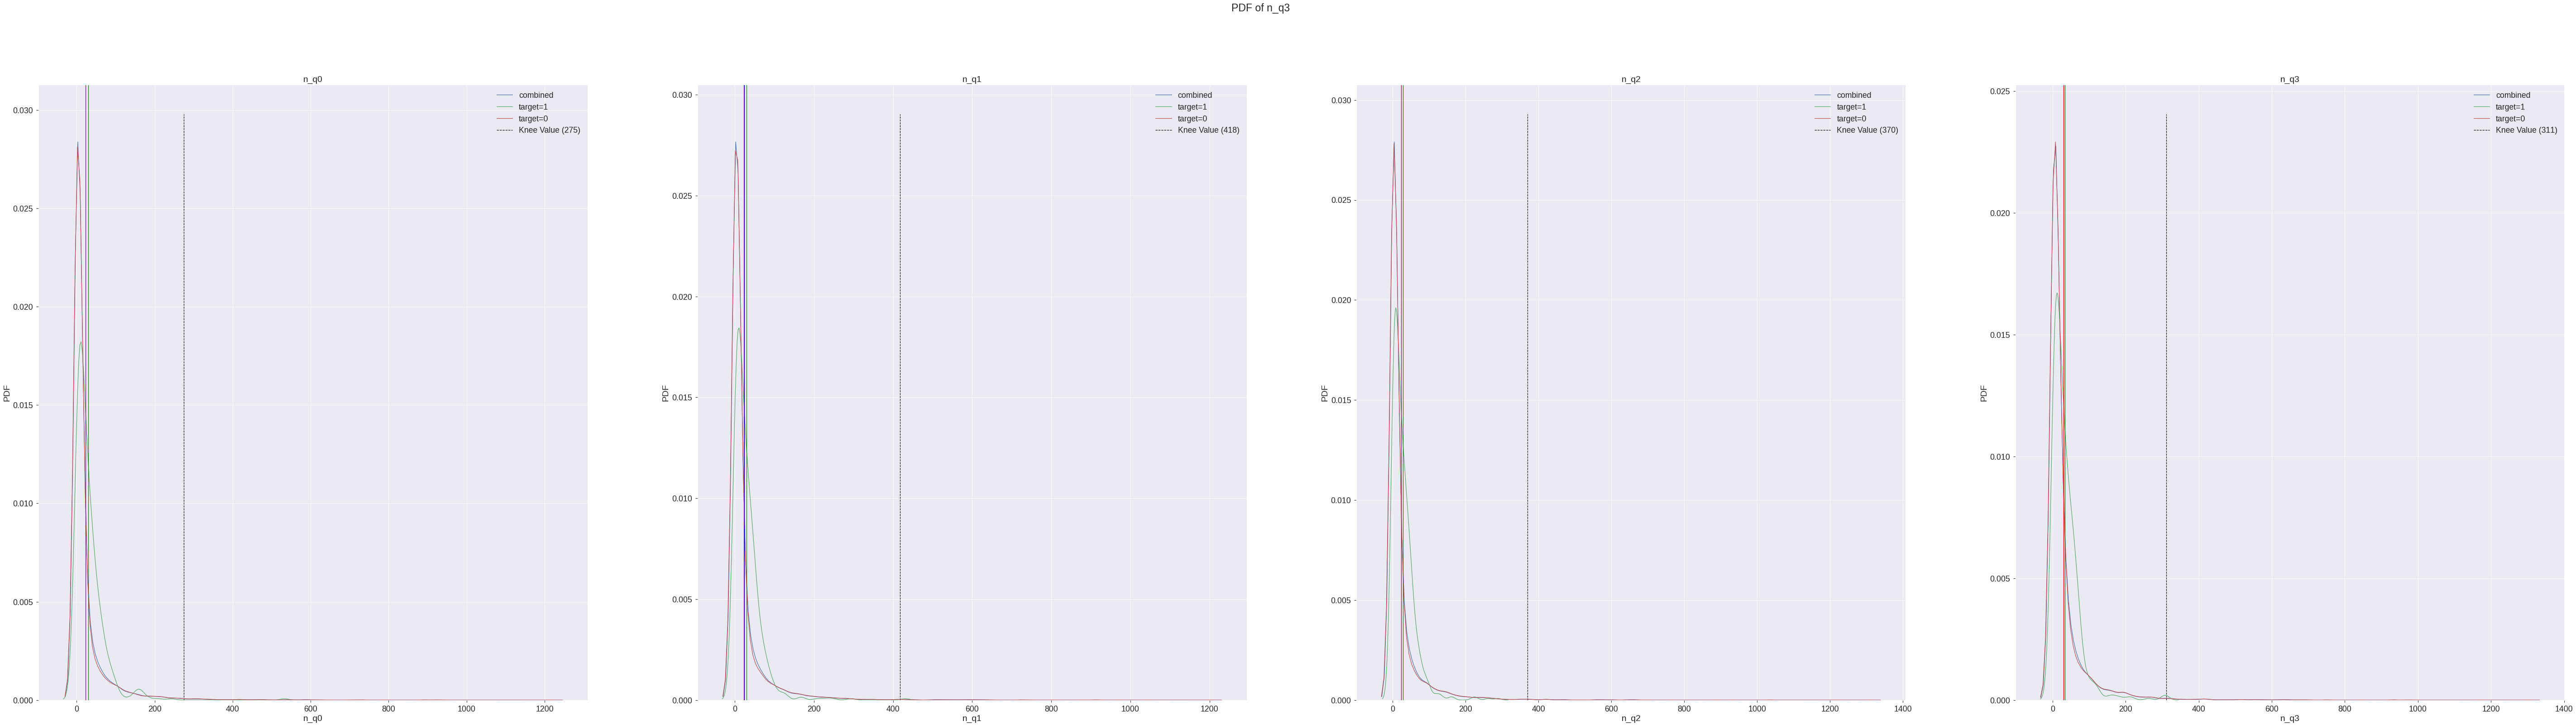

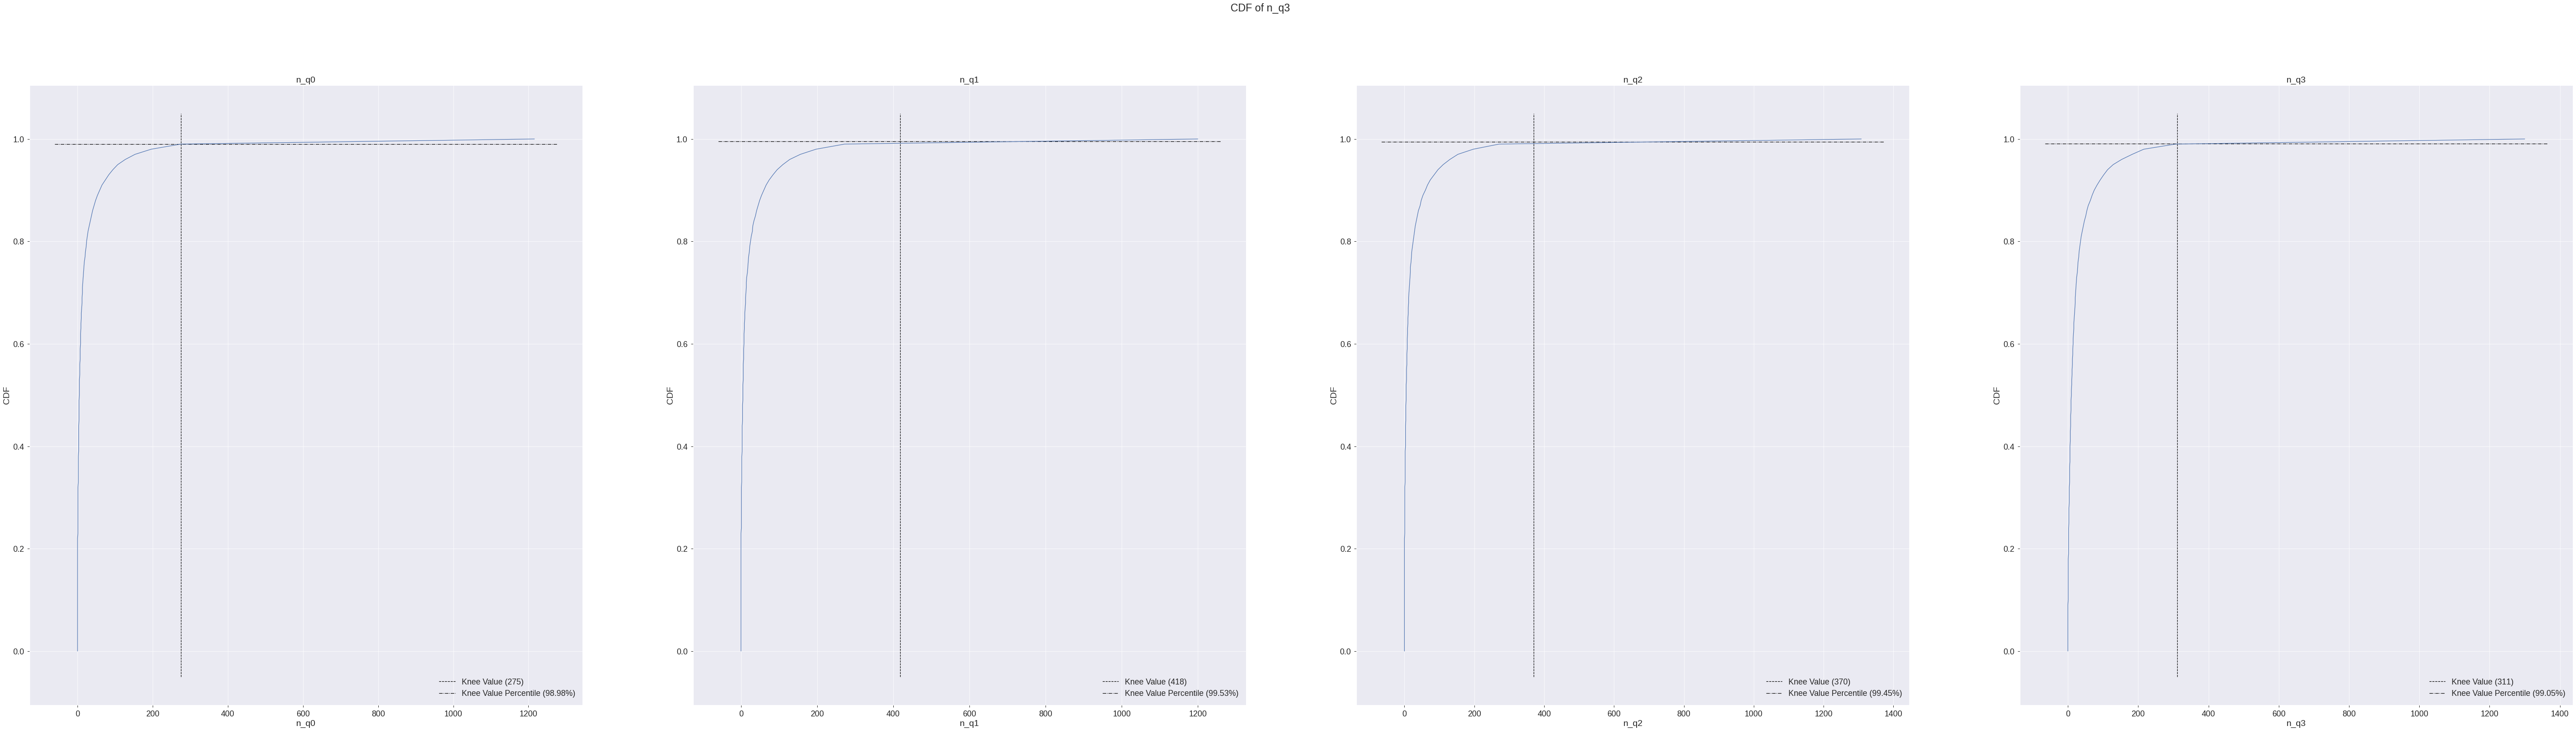

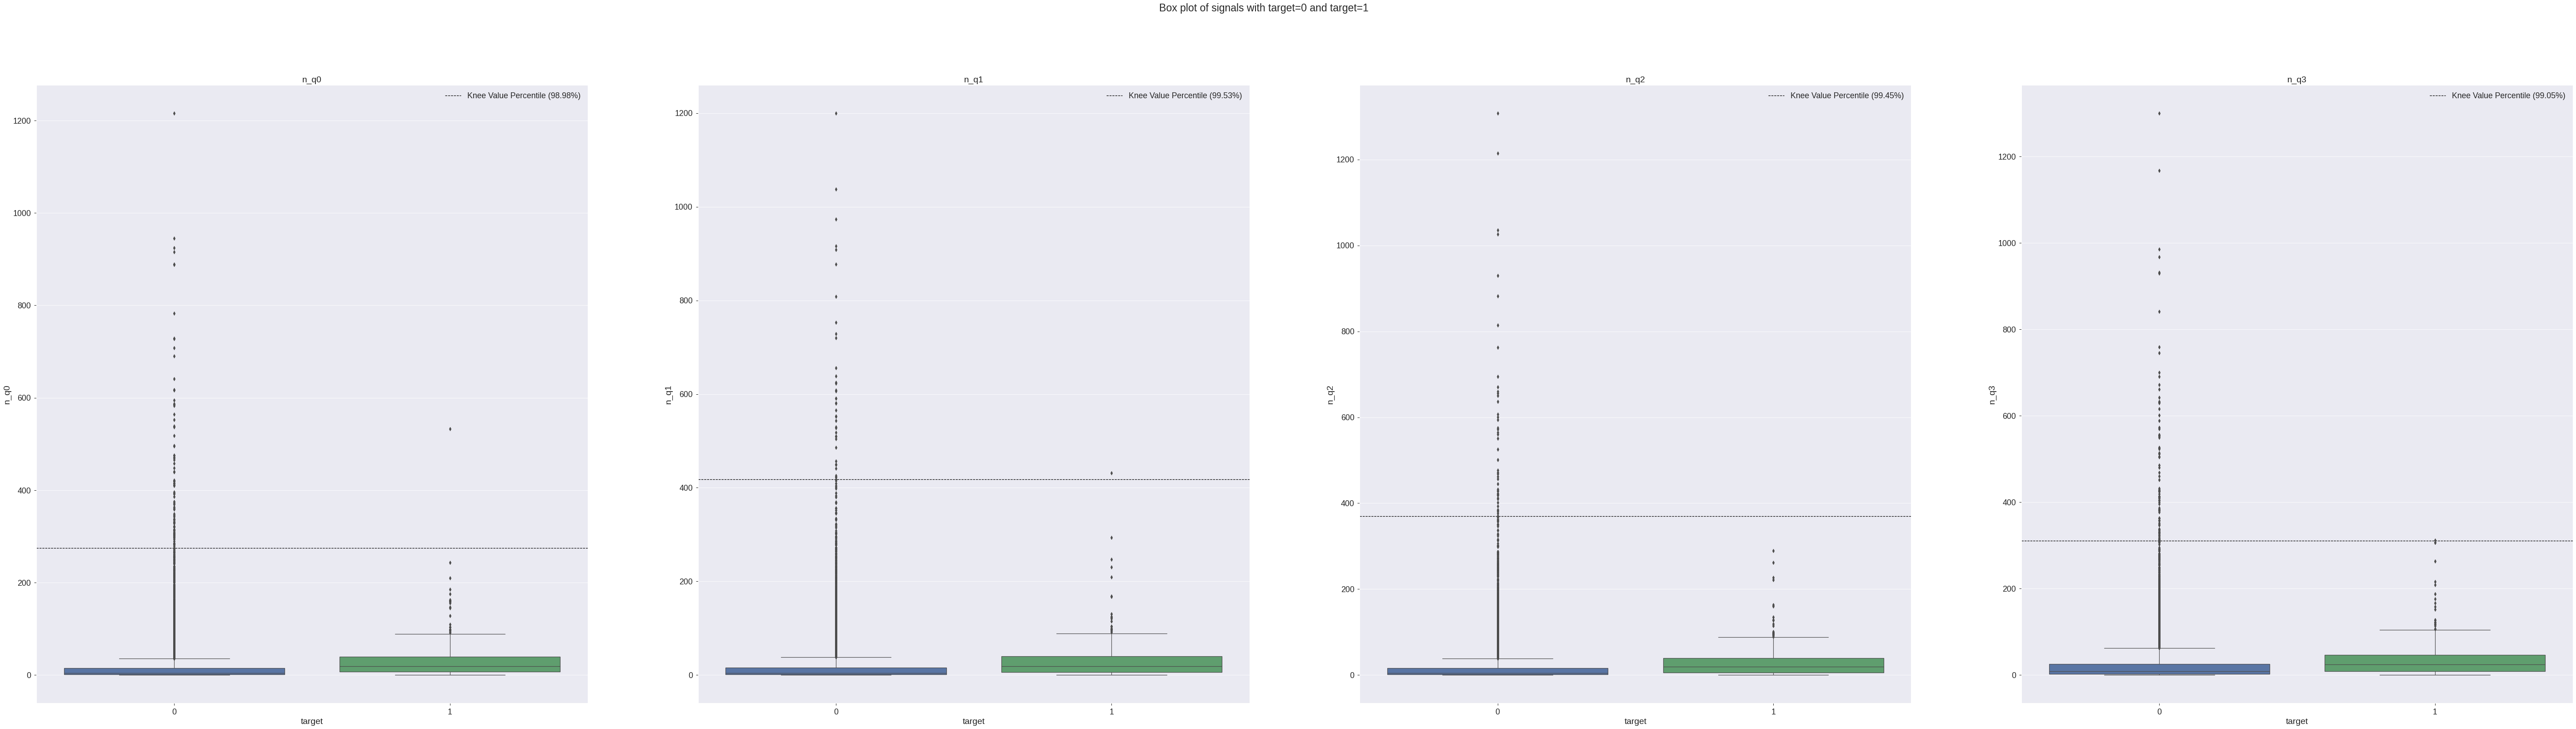

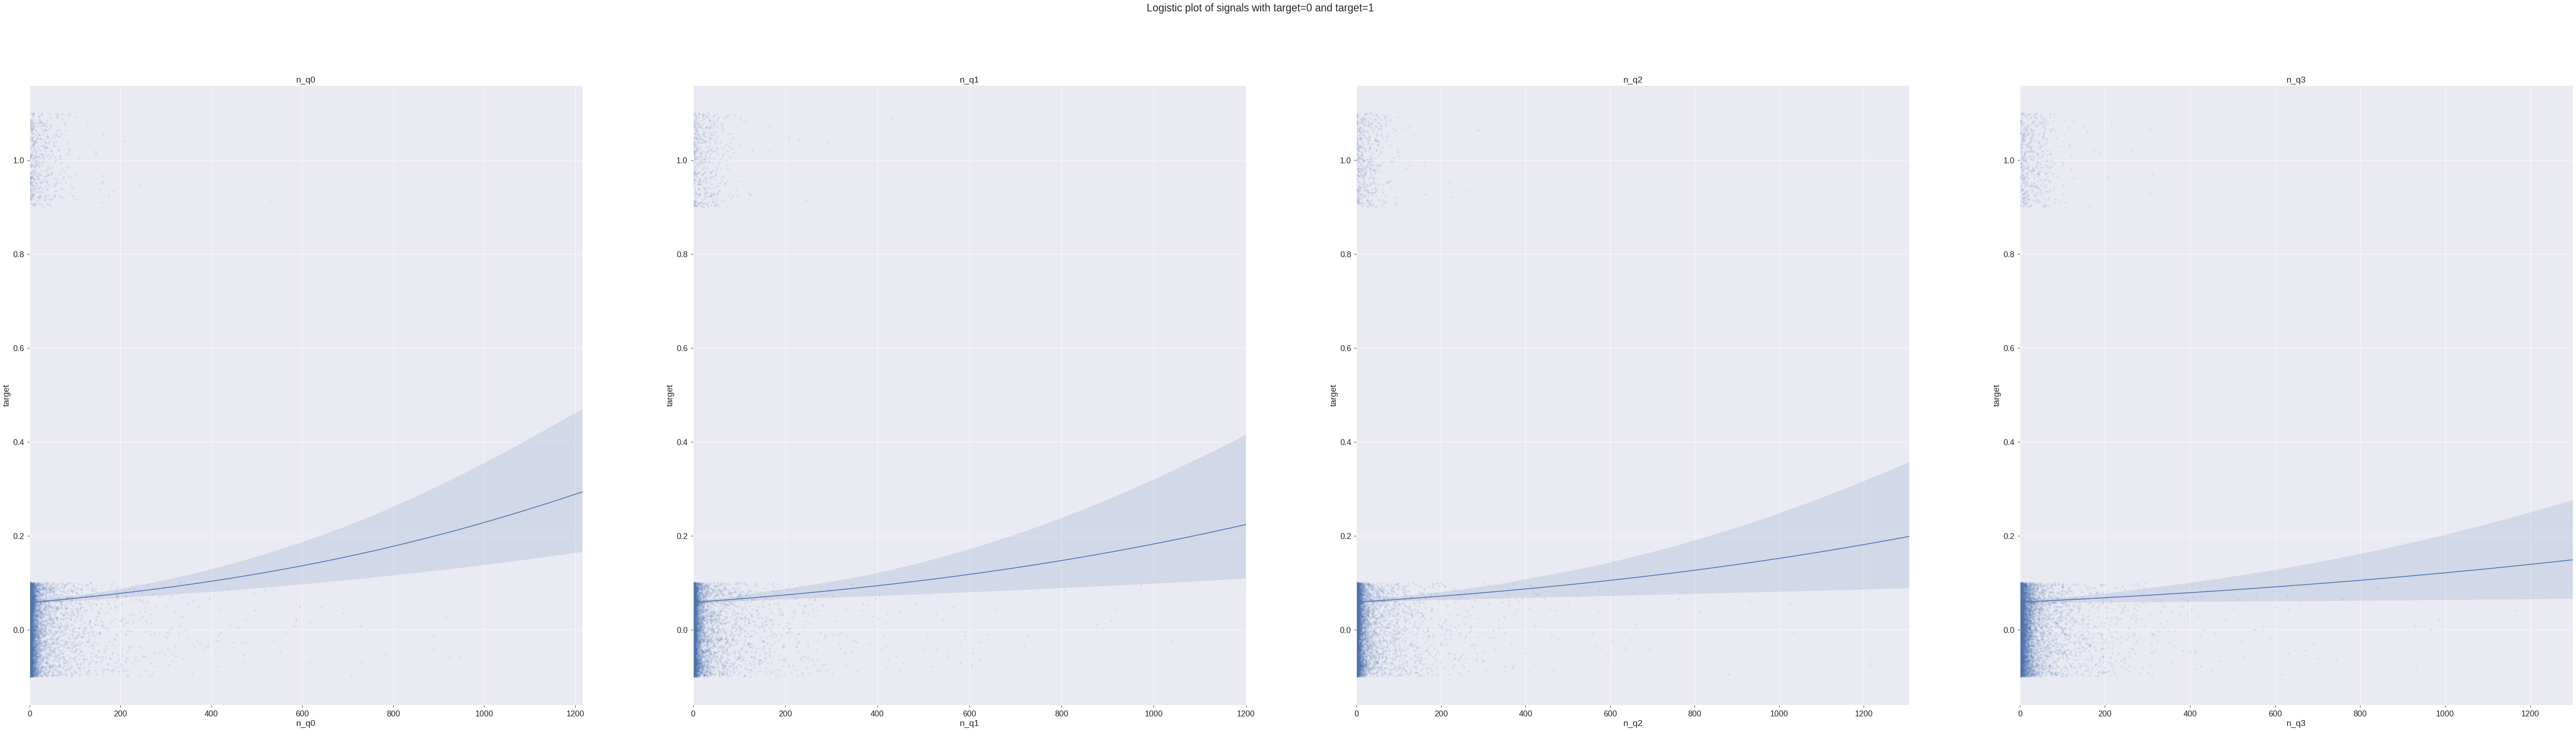

In [ ]:
feat_list = ['n_q0', 'n_q1', 'n_q2', 'n_q3']
plot_multi_compare(feat_list, 'one_phase', plt_list, phase_resolve_df)

Observations:
*  Most of the positive peaks in each quadrant is less than 400
*  IQRs of signals with target=1 and target=0 do overlaps in all the quadrants.
*  Positive peaks in any of the quadrant is not good enough to be separated linearly.

#### Test data

In [ ]:
phase_cols = ['t_q0', 't_q1', 't_q2', 't_q3',
              'f_q0', 'f_q1', 'f_q2', 'f_q3',
              'p_q0', 'p_q1', 'p_q2', 'p_q3',
              'n_q0', 'n_q1', 'n_q2', 'n_q3']

save_file_path = path + f'test_path/phase_resolved_peaks_test.csv'

if not os.path.isfile(save_file_path):
  peak_val = int(np.load(path + f'temp_files/best_peak_threshold.npy'))

  start_time = datetime.now()
  print(f"Start time: {start_time}")

  parallel_proc_func(phase_resolve, phase_cols, metadata_test.shape[0], metadata_test['signal_id'].loc[0], 
                     save_file_path, ('test', phase_cols, peak_val))

  print(f"Total time taken: {datetime.now()-start_time}")

phase_resolve_df = pd.read_csv(save_file_path)
phase_resolve_df.drop(['Unnamed: 0'], axis=1, inplace=True)

print(phase_resolve_df.shape)
phase_resolve_df.head()

(20337, 16)


t_q0  t_q1  t_q2  t_q3  f_q0  f_q1  ...  p_q2  p_q3  n_q0  n_q1  n_q2  n_q3
0    27    54    28    29    36   295  ...    15    18    17    42    13    11
1    21     4    29     5    14     3  ...    19     1    20     2    10     4
2    20    20    60    22    46    16  ...    39    13    15    13    21     9
3     0     0     0     1     0     0  ...     0     0     0     0     0     1
4    44    17    33    21    13     0  ...    19    10    22     7    14    11

[5 rows x 16 columns]